## Import packages

In [1]:
#General
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

In [2]:
# Building the models
#!pip install imblearn
#!pip install yellowbrick
from scipy import stats

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold, RepeatedKFold
from sklearn.feature_selection import f_classif, VarianceThreshold, SelectKBest, f_regression
from sklearn.feature_selection import RFECV, f_classif, VarianceThreshold, SelectKBest, f_regression
from yellowbrick.model_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC


#from sklearn.preprocessing import LabelEncoder, MinMaxScaler
#from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
#from sklearn.linear_model import LogisticRegression, SGDClassifier

#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.naive_bayes import GaussianNB
#import xgboost as xgb
#from xgboost import XGBClassifier

#from sklearn.metrics import roc_auc_score, plot_roc_curve
#from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

#import statistics

## Read the data 

In [3]:
# Read the data
df = pd.read_csv('data.csv')
columns = df.columns
print(df.shape)
print("total null values", df.isnull().sum().sum())
print("total potential duplicated rows", df.duplicated().sum())

(6819, 96)
total null values 0
total potential duplicated rows 0


In [4]:
# Data info overall
bankrupt, bankrupt_perc = (df["Bankrupt?"].value_counts(), round(df["Bankrupt?"].value_counts(normalize=True),2))
display(bankrupt, bankrupt_perc)
print("----------------------------------")
df.info()

0    6599
1     220
Name: Bankrupt?, dtype: int64

0    0.97
1    0.03
Name: Bankrupt?, dtype: float64

----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-nul

## Initial EDA

In [5]:
# Visulize outcome's distribution using barplot
fig = px.bar(x=df['Bankrupt?'].value_counts().index, 
             y=df['Bankrupt?'].value_counts(), 
             text=(df['Bankrupt?'].value_counts()/len(df['Bankrupt?'])*100),
             height=500, width=600, title='Bankrupcy')
fig.update_traces(textposition='outside', texttemplate='%{text:.4s}%', 
                  marker=dict(color='snow', line=dict(color='black', width=3)))
fig.show()

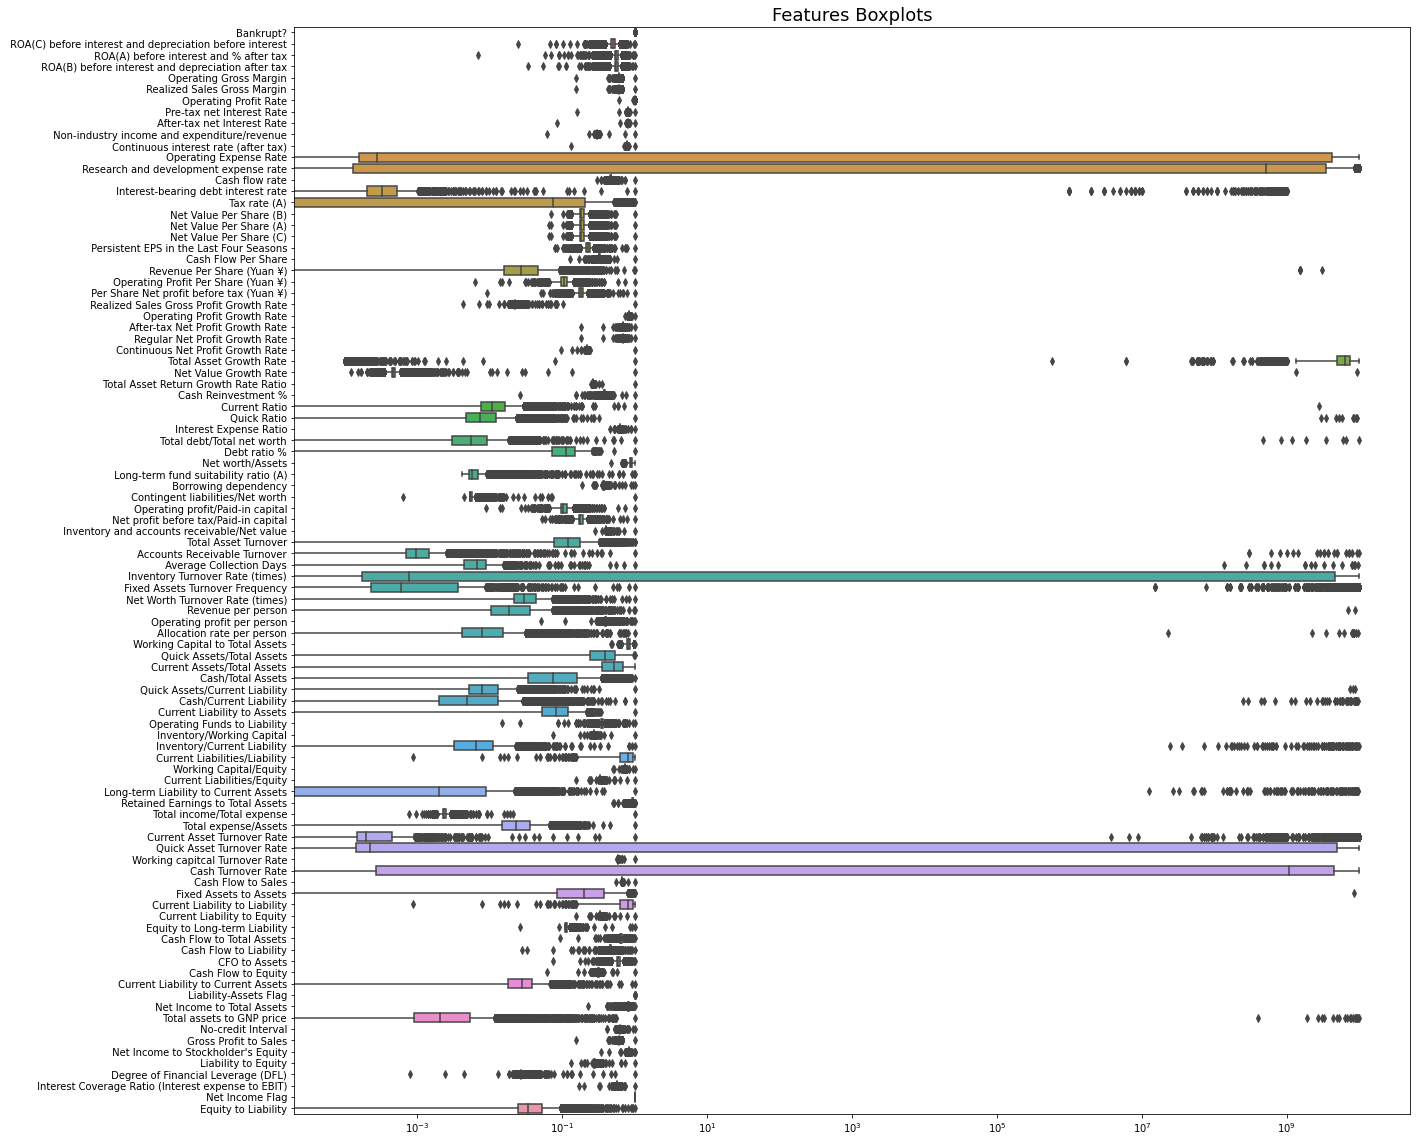

In [68]:
# Visulize variables' distribution using boxplots
plt.figure(figsize = (20,20))
ax = sns.boxplot(data= df, orient="h")
ax.set_title('Features Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

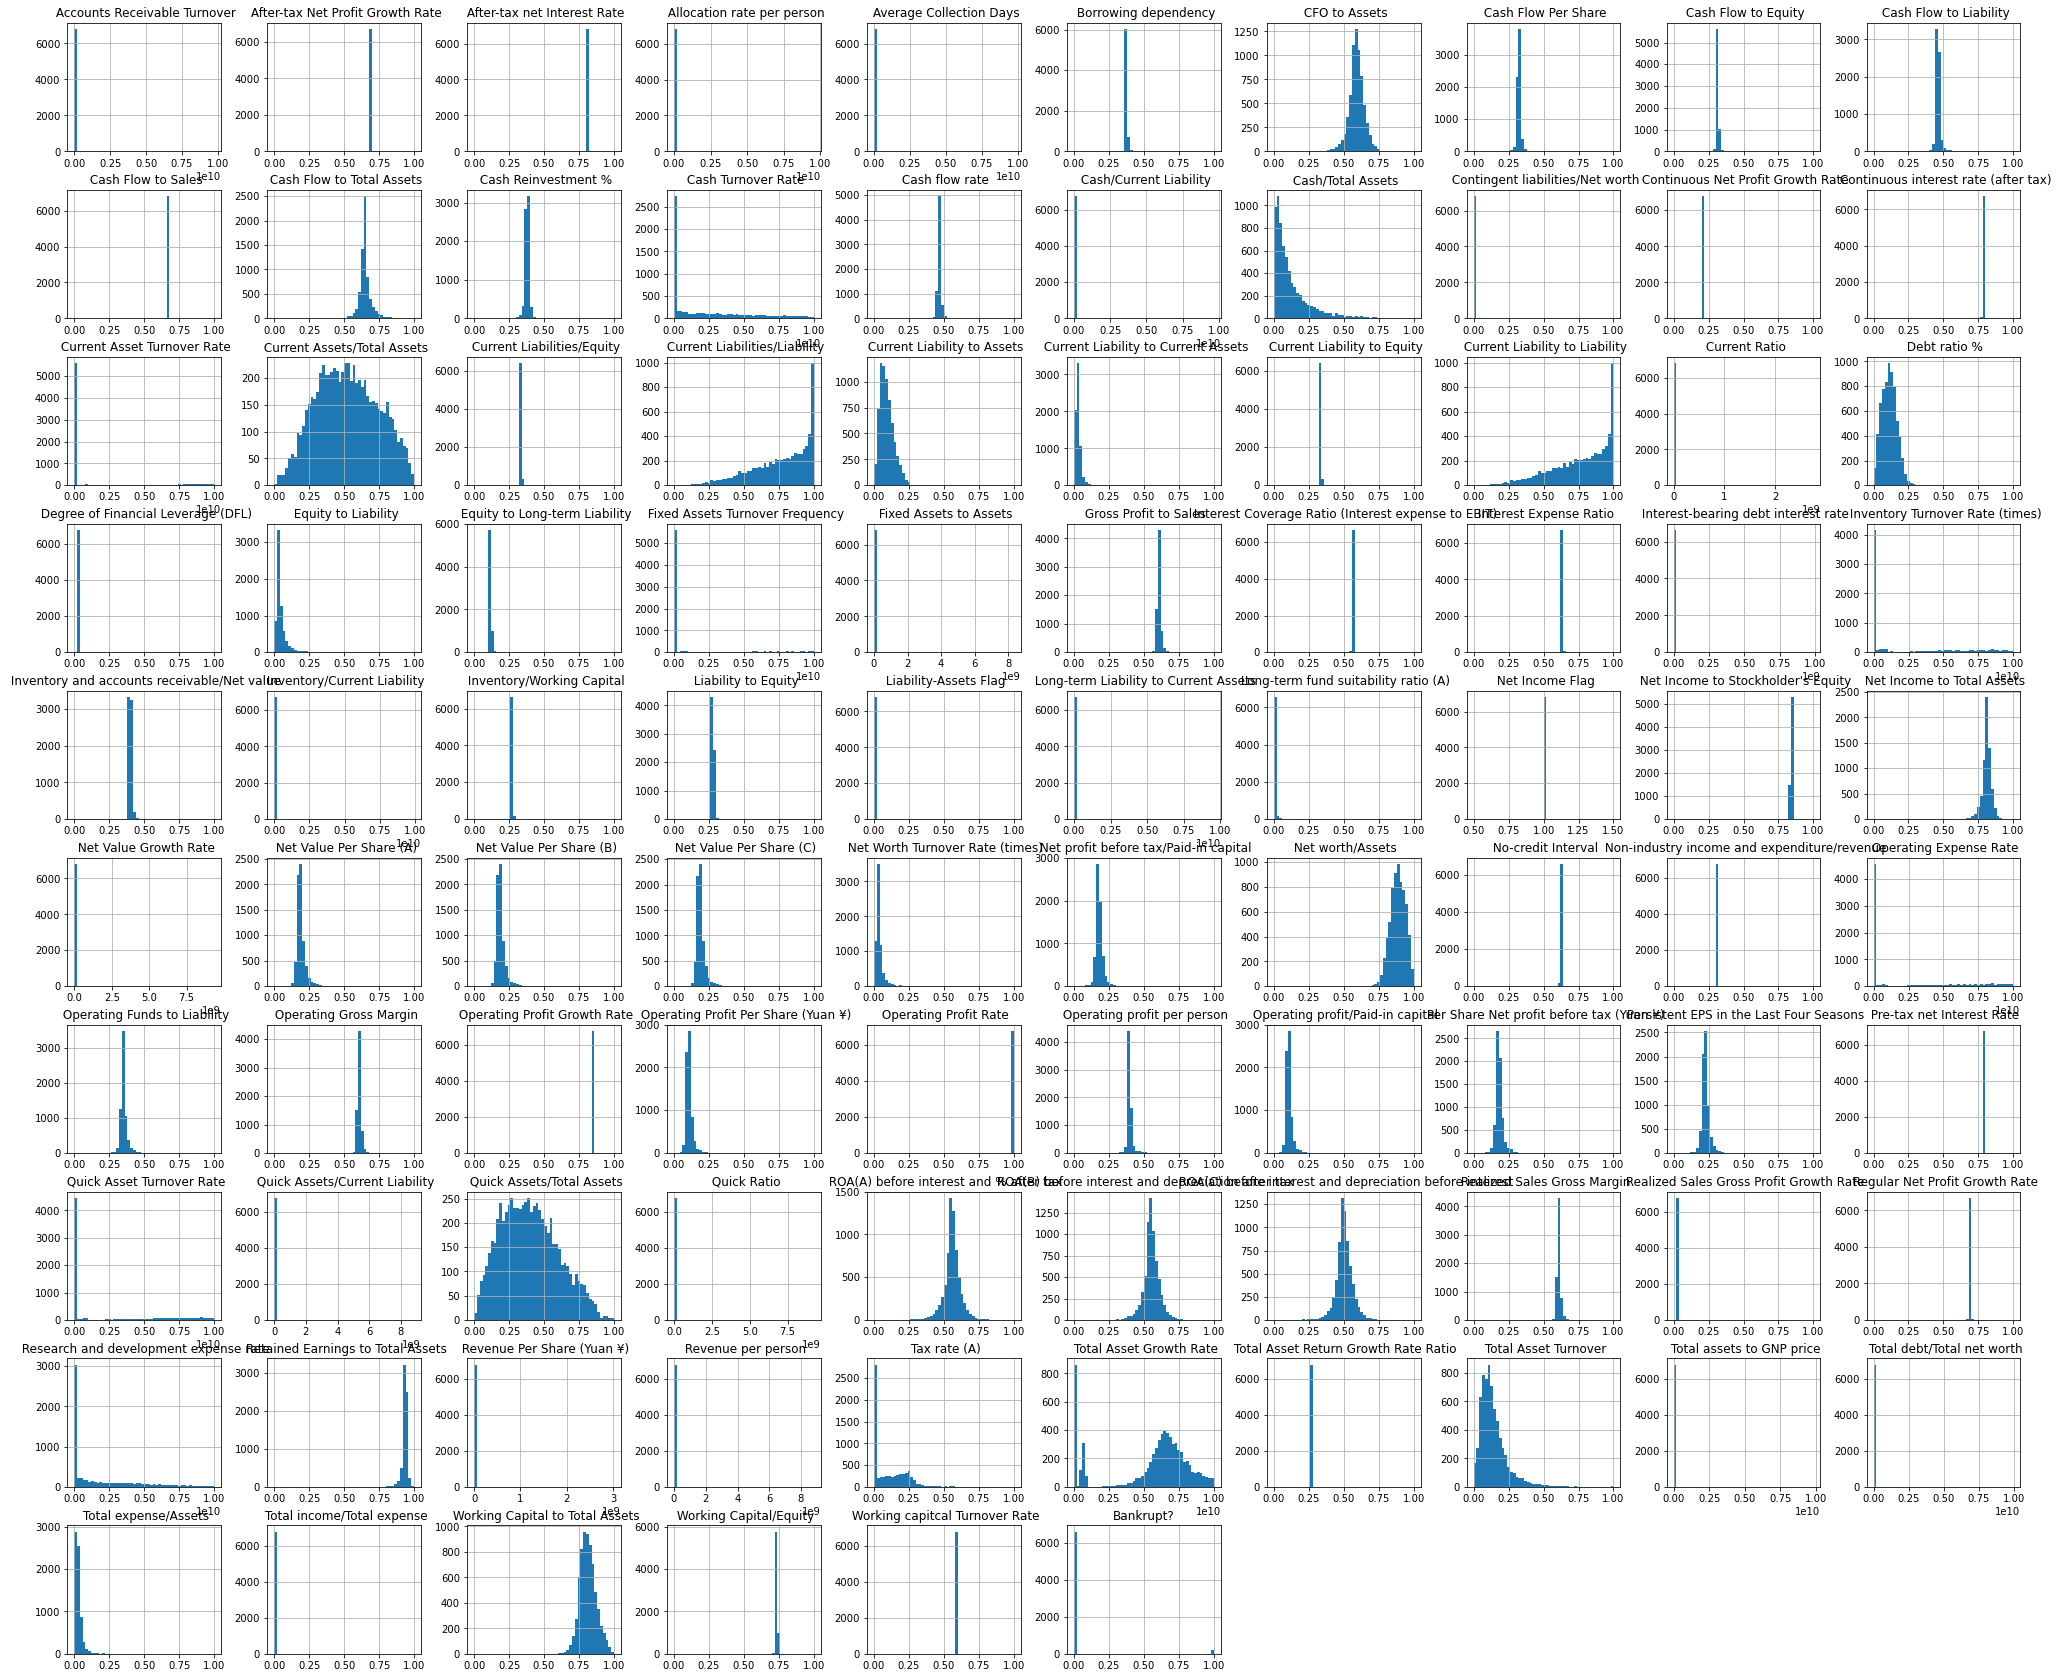

In [69]:
# Visulize numerical data's distribution using histograms
df.hist(figsize = (35,30), bins = 50)
plt.show()

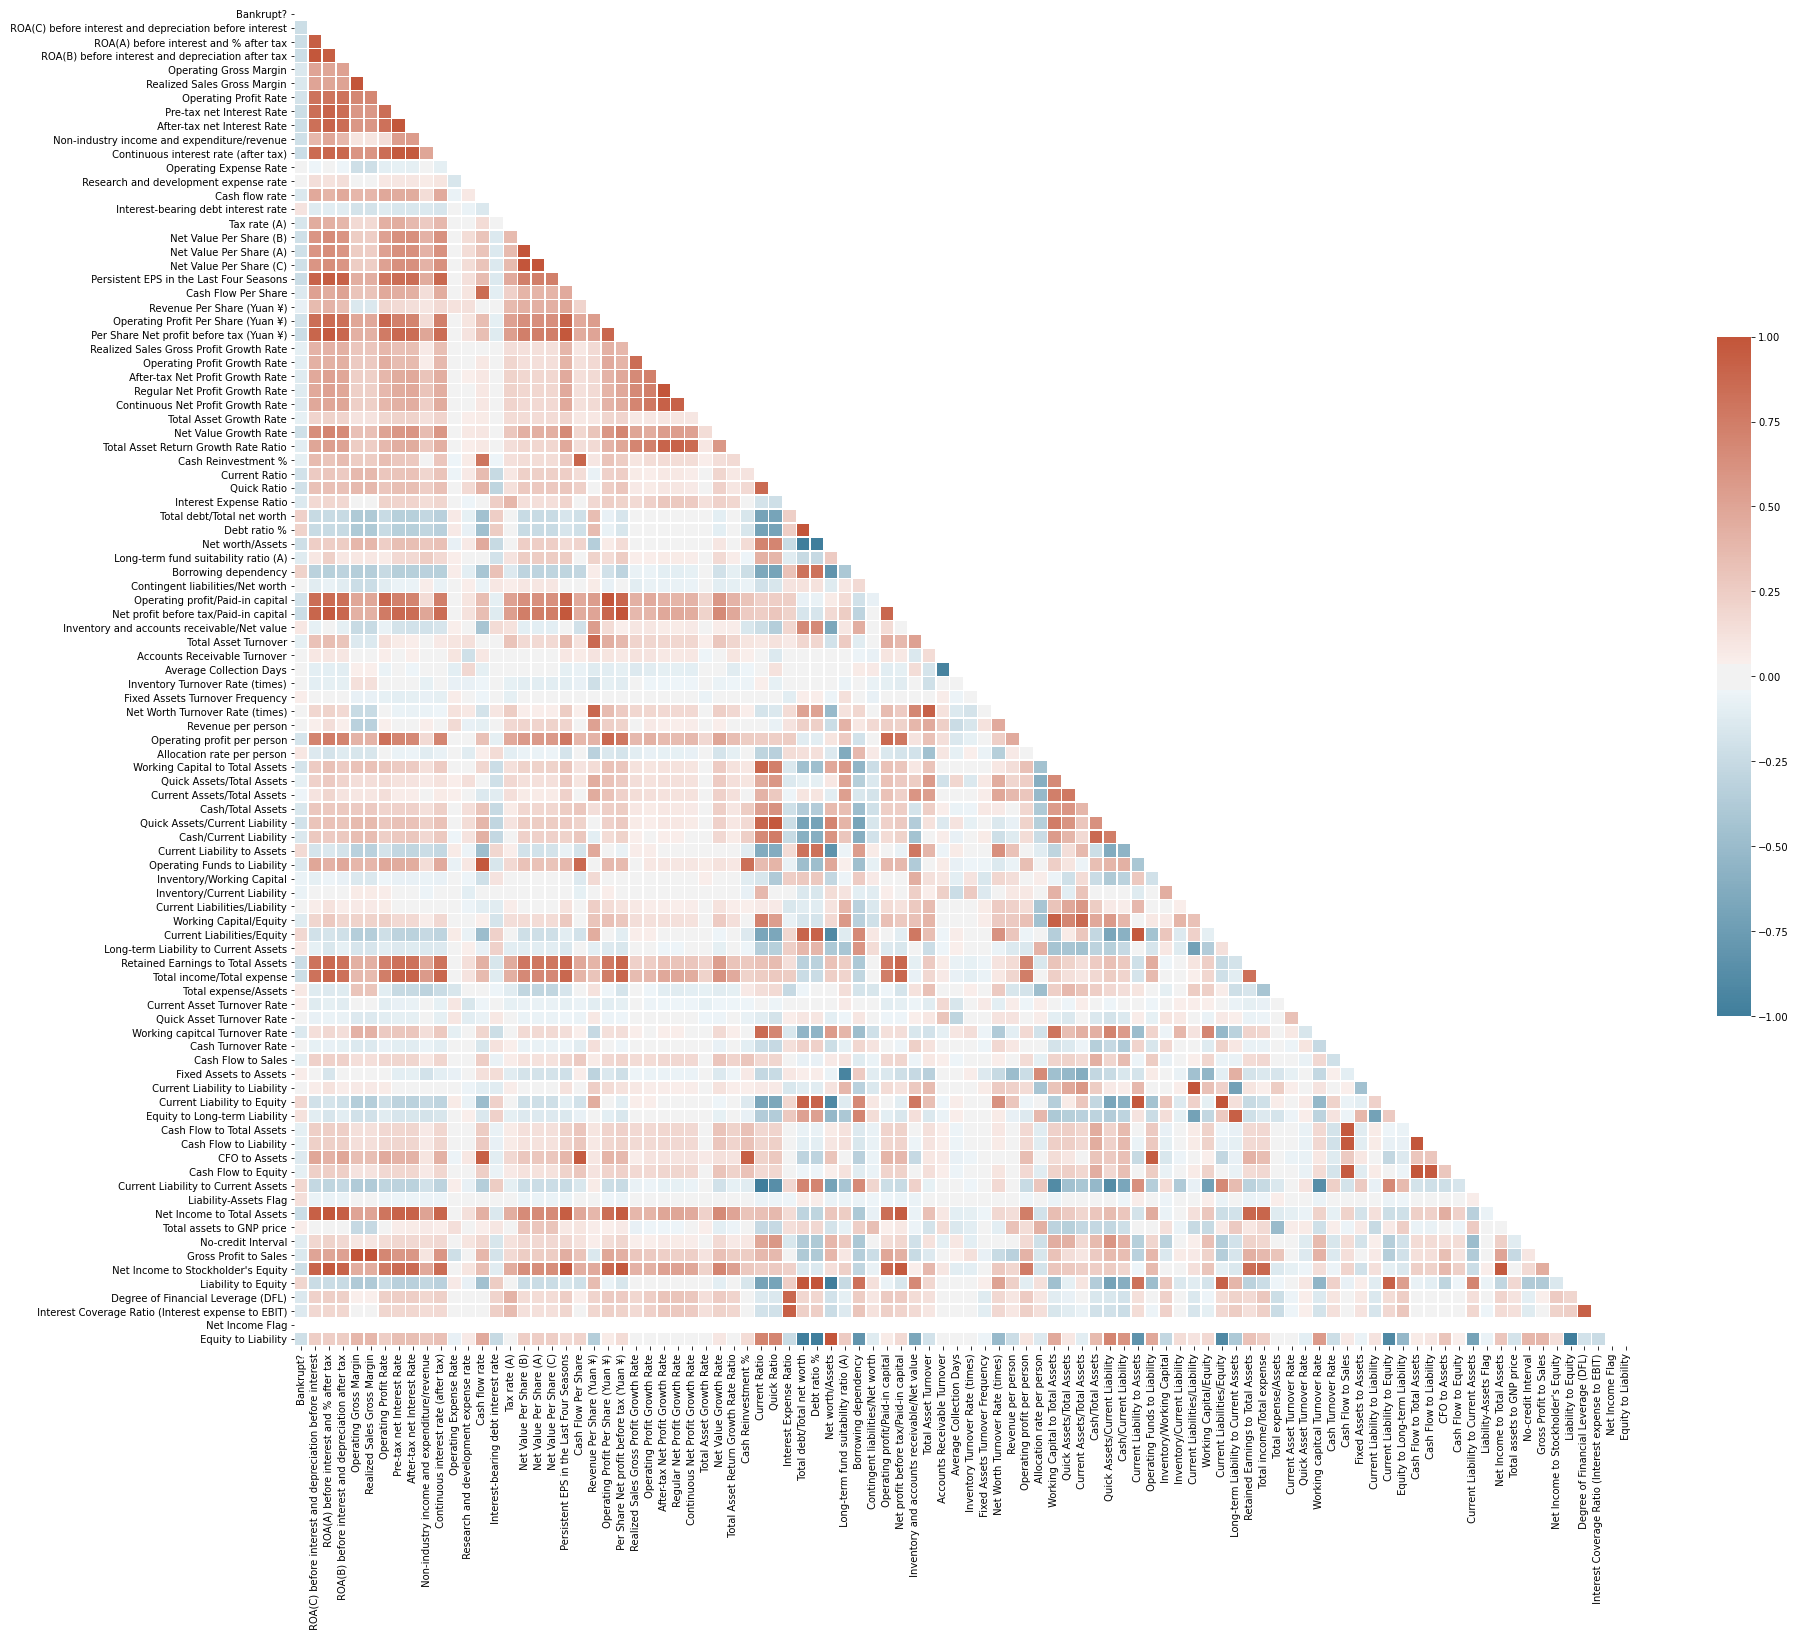

In [70]:
# Correlation Heatmap (Spearman)
df.corr('spearman')["Bankrupt?"].sort_values() 
f, ax = plt.subplots(figsize=(30, 25))
mat = df.corr('spearman')  
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

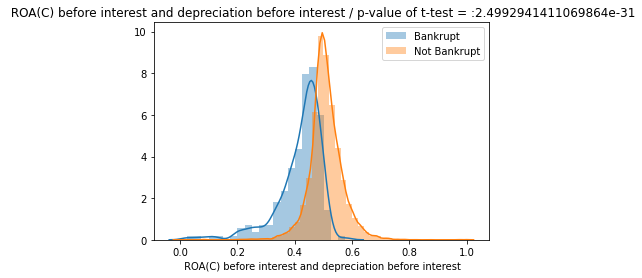

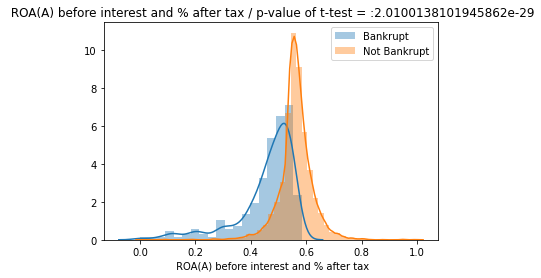

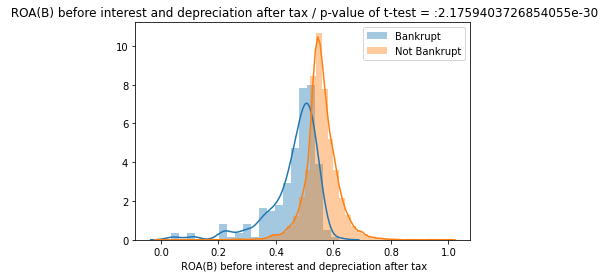

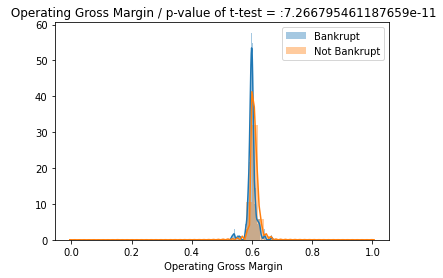

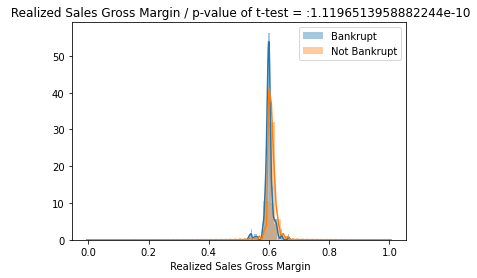

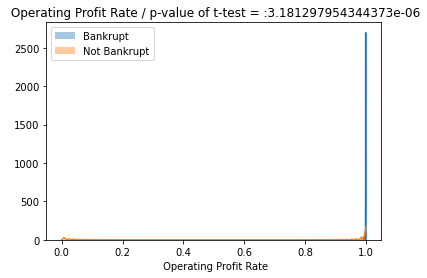

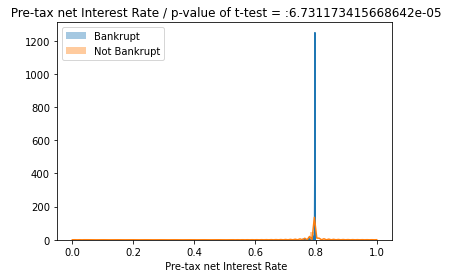

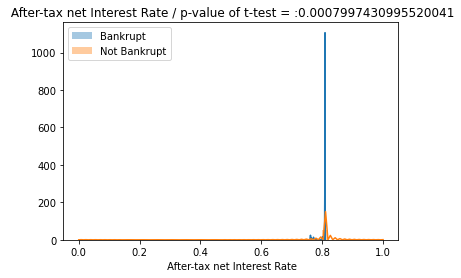

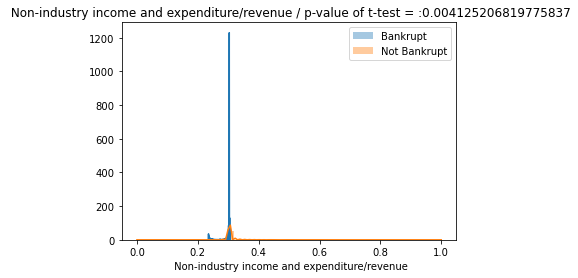

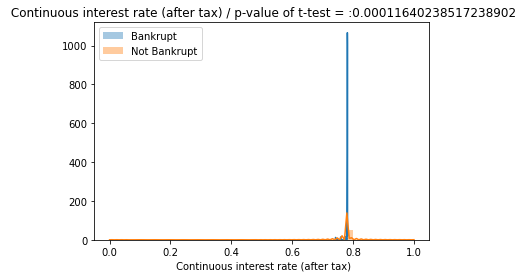

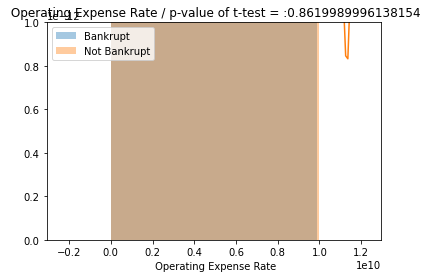

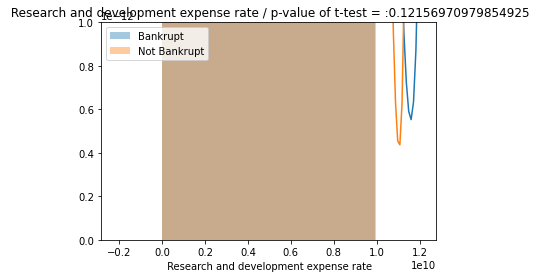

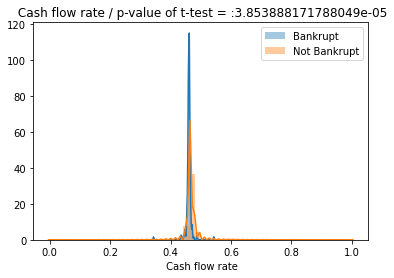

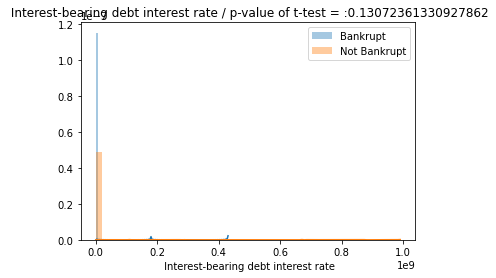

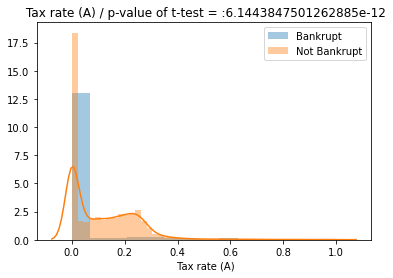

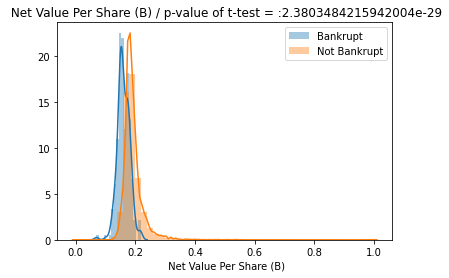

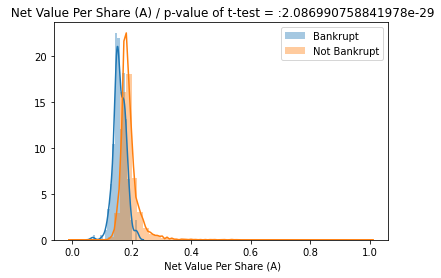

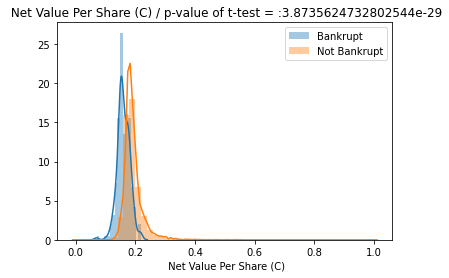

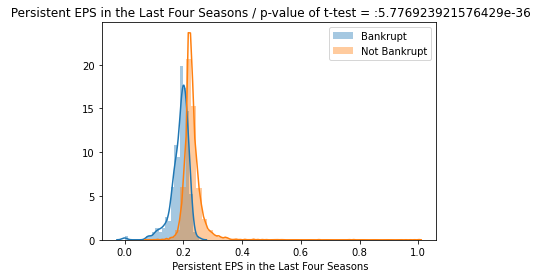

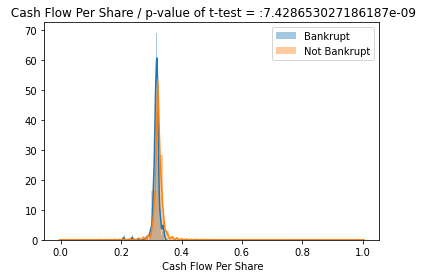

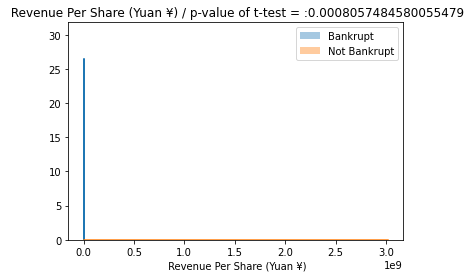

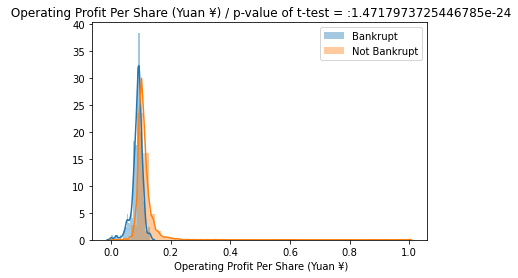

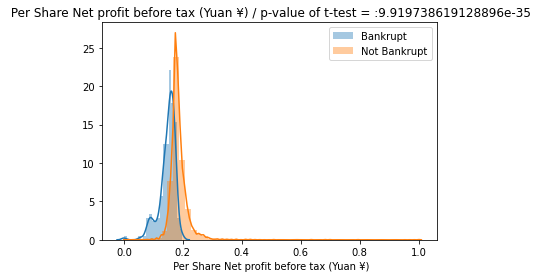

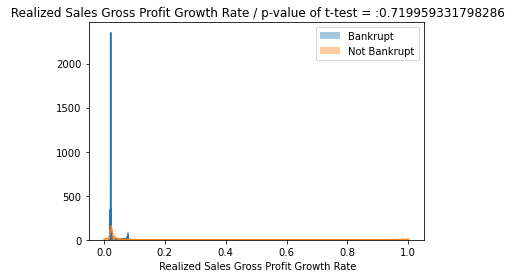

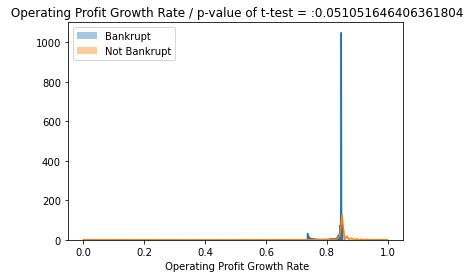

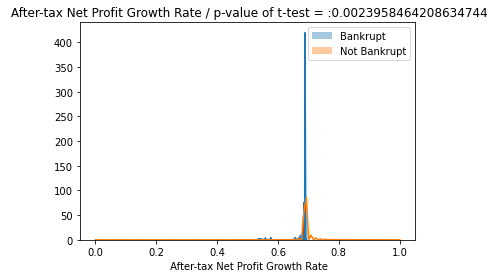

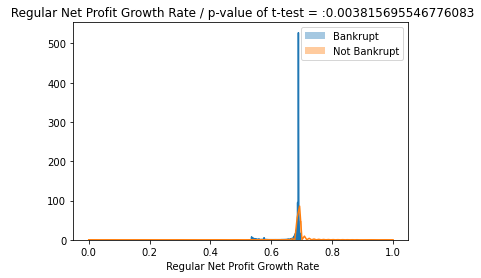

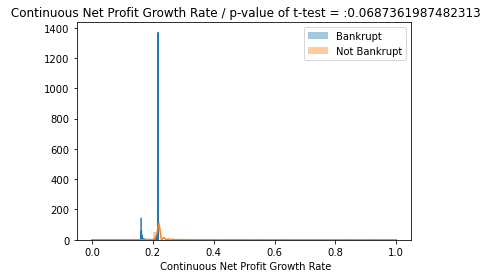

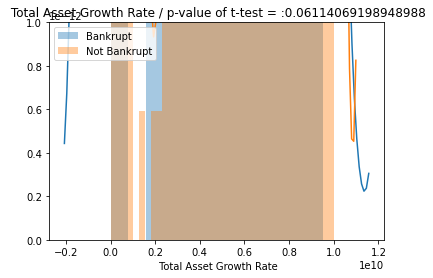

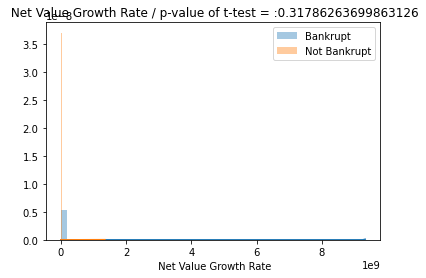

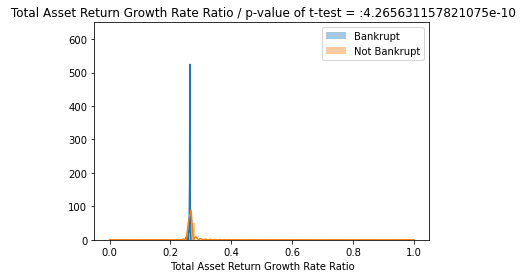

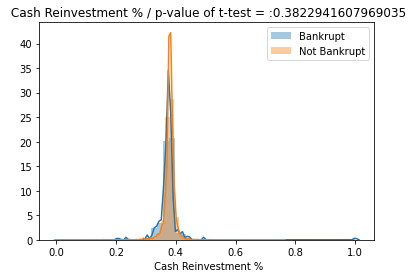

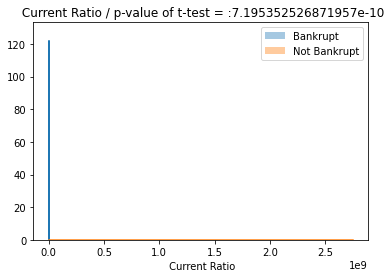

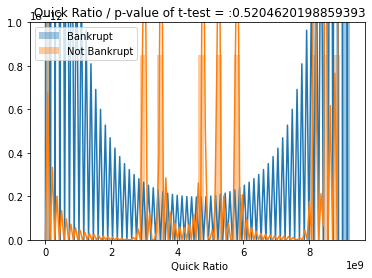

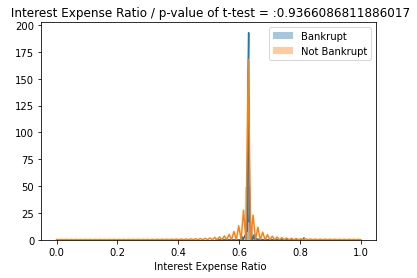

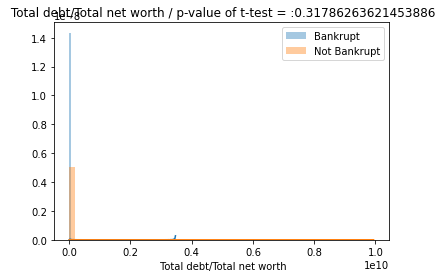

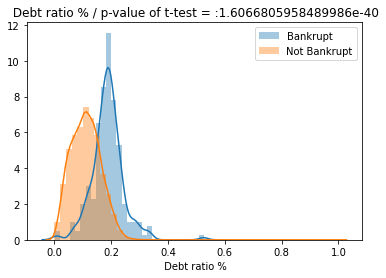

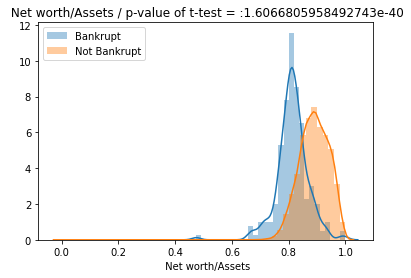

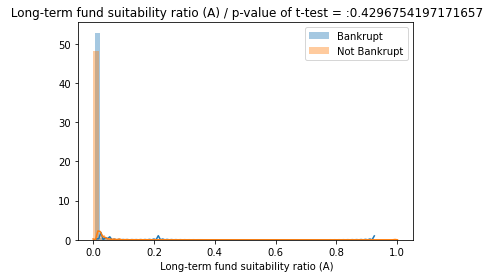

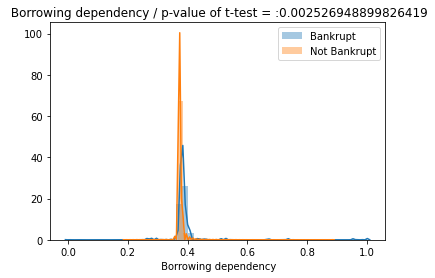

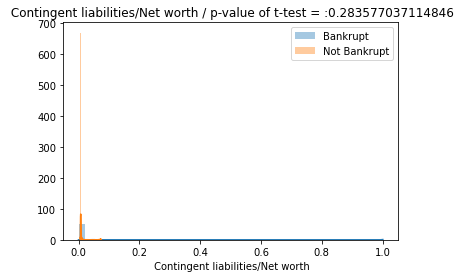

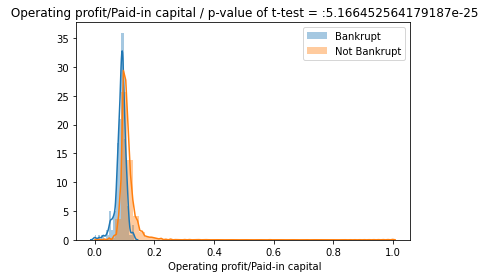

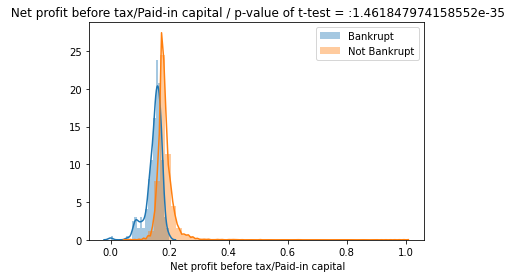

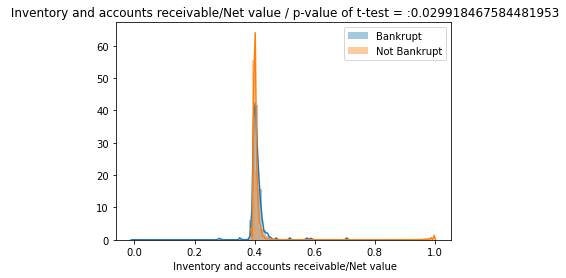

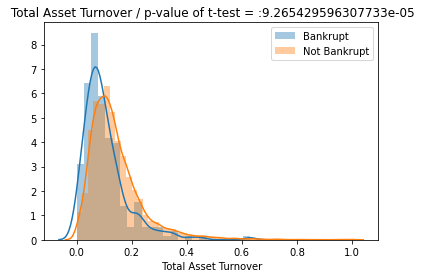

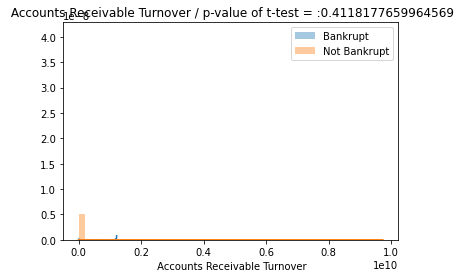

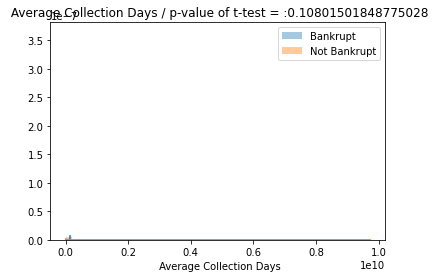

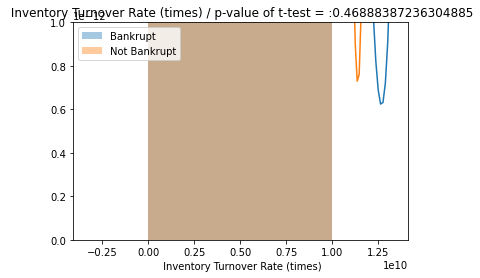

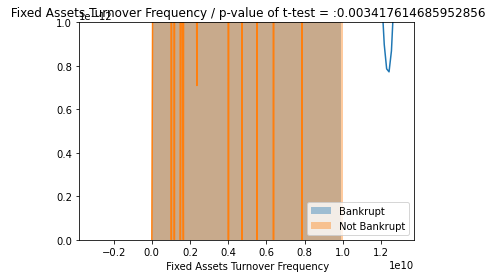

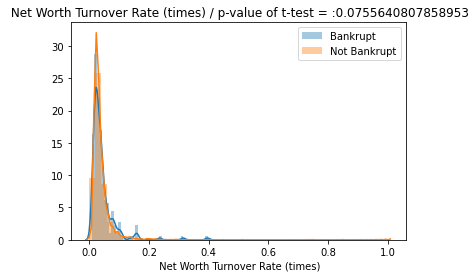

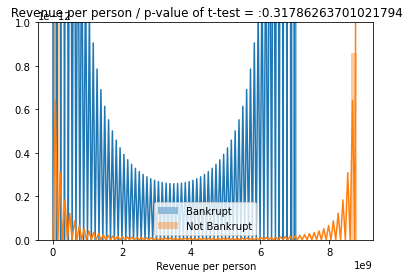

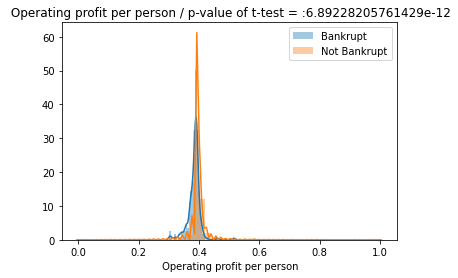

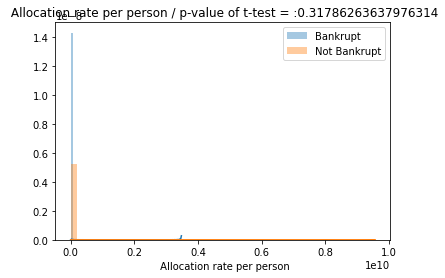

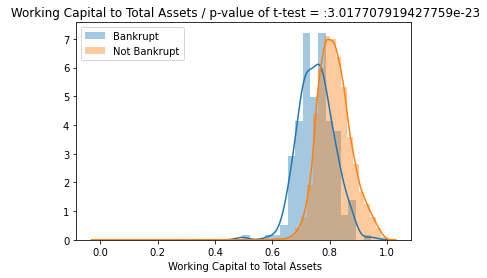

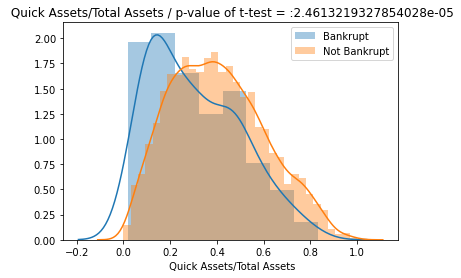

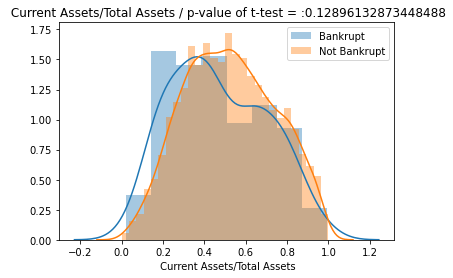

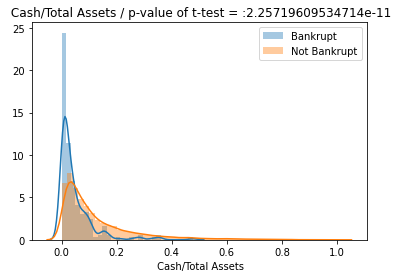

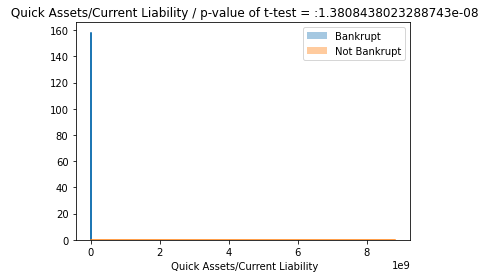

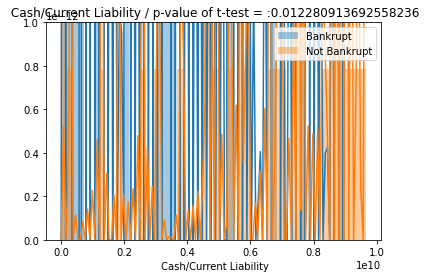

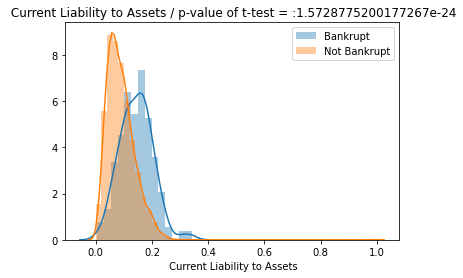

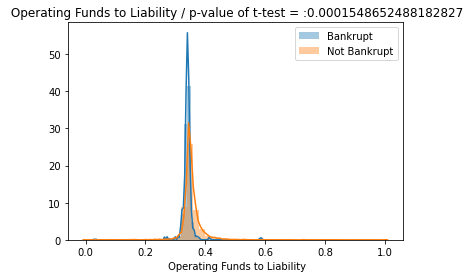

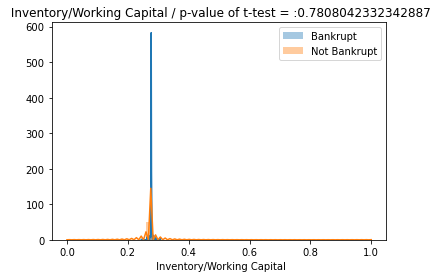

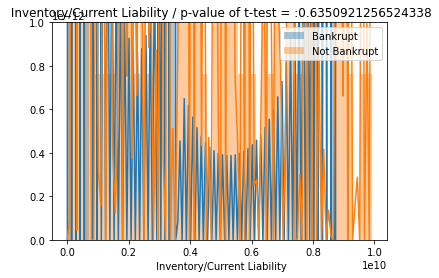

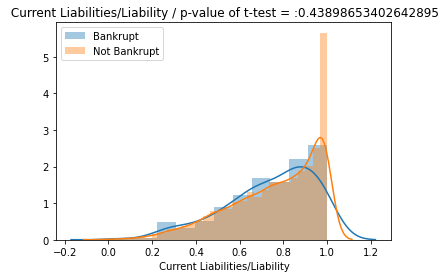

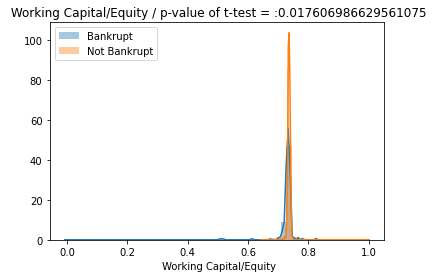

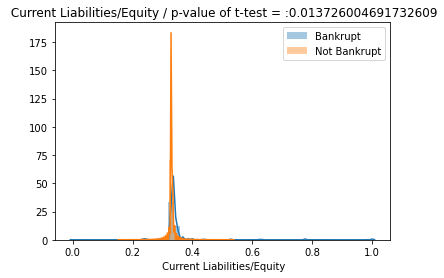

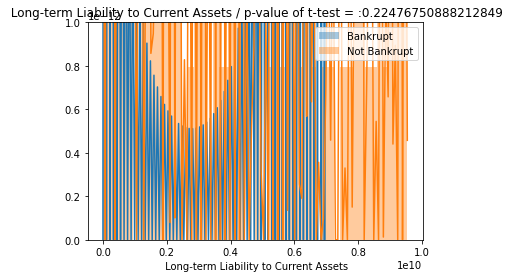

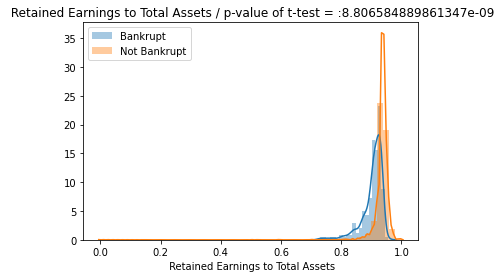

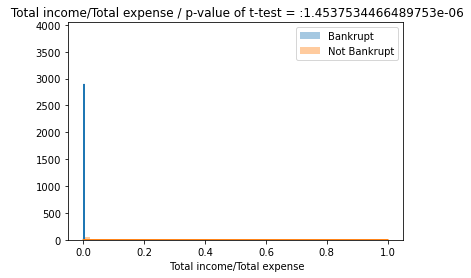

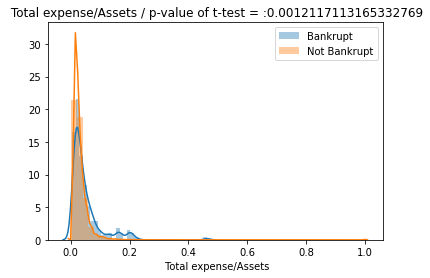

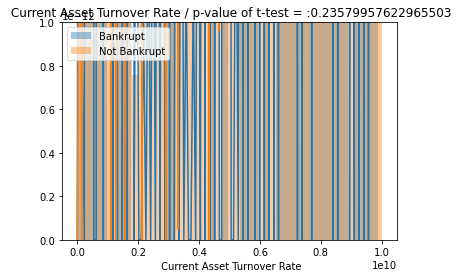

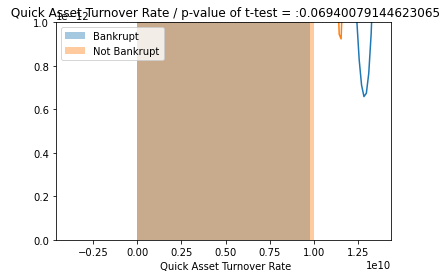

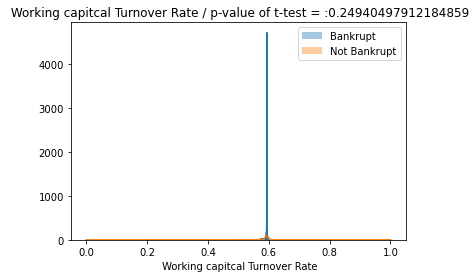

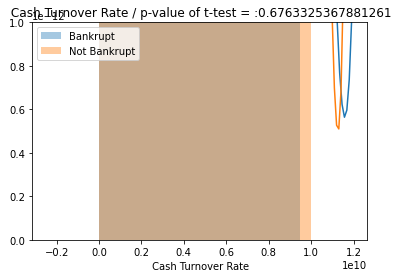

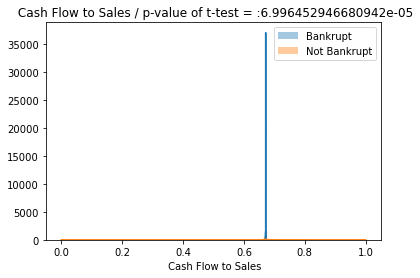

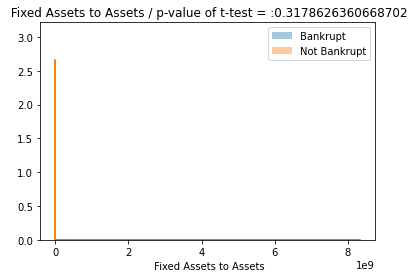

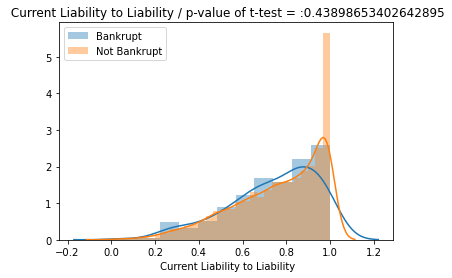

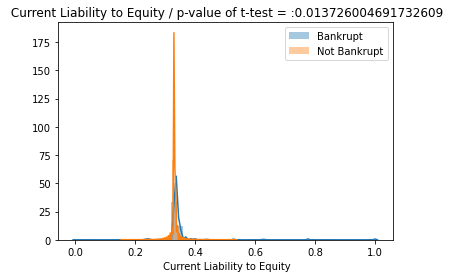

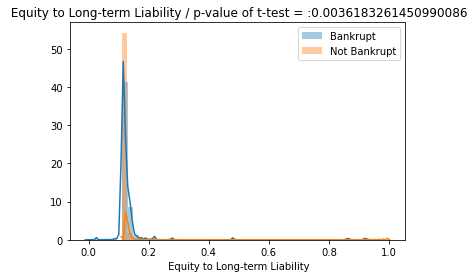

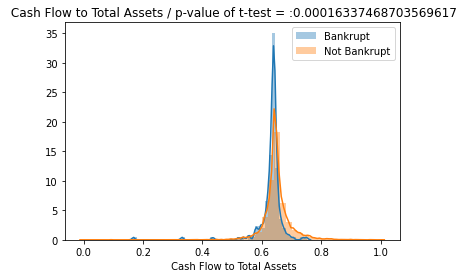

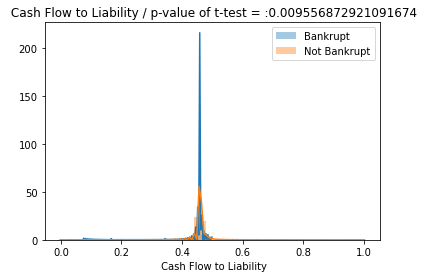

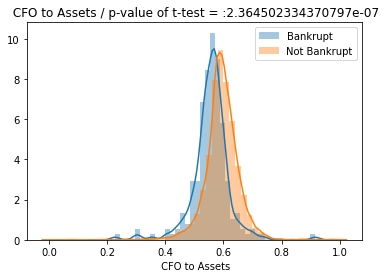

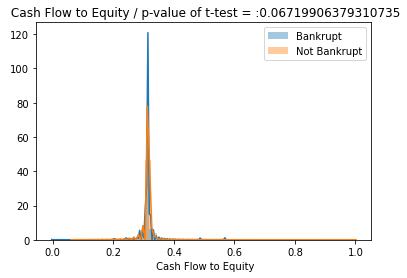

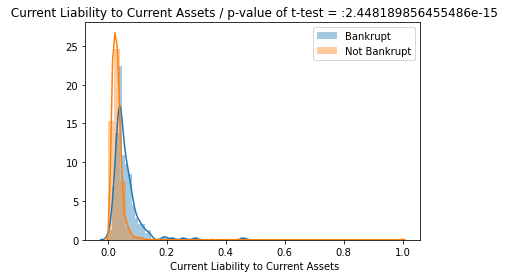

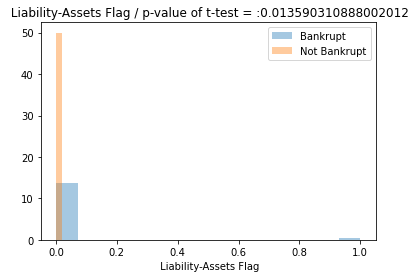

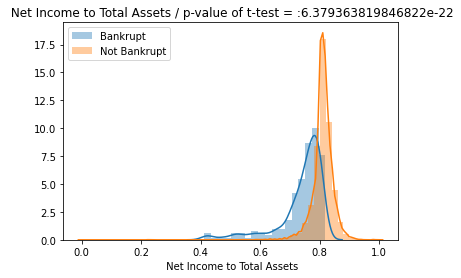

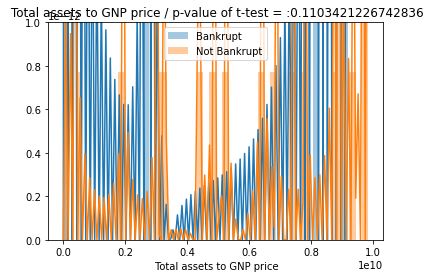

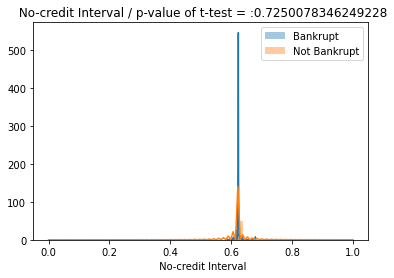

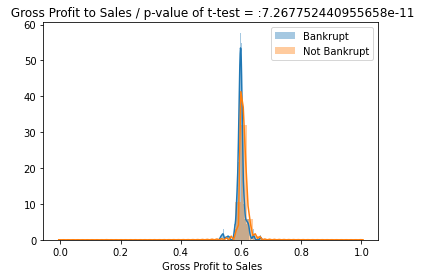

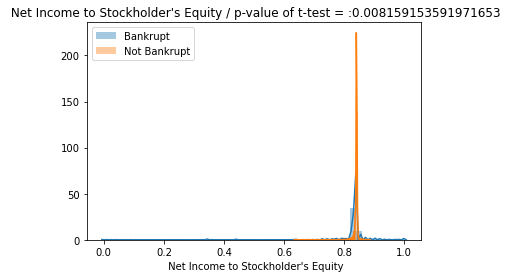

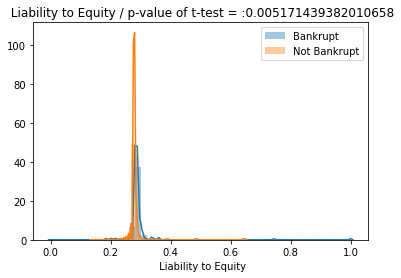

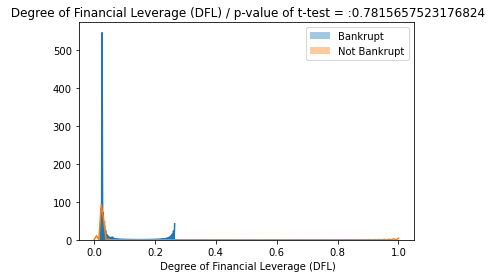

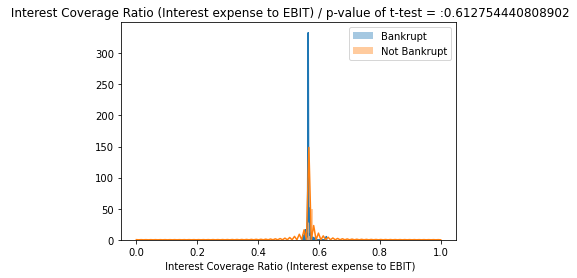

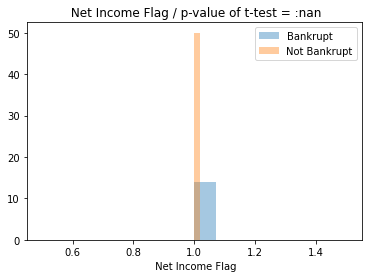

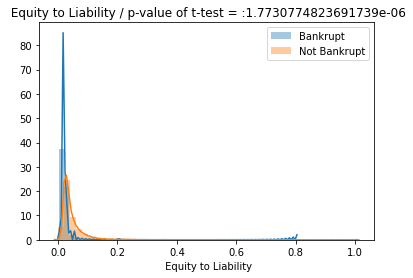

In [71]:
# Analyze variance and hypothesis testing of all features
bankrupt_df = df[df['Bankrupt?']==True]
not_bankrupt_df = df[df['Bankrupt?']==False]

cols = df.drop("Bankrupt?", axis=1).columns

for feature in cols:
  a = bankrupt_df[feature]
  b = not_bankrupt_df[feature]
  b = b.sample(n=len(a), random_state=42) # Take random sample from each feature to match length of target

  test = stats.ttest_ind(a,b)   # Running t-tests
  plt.figure() 
  sns.distplot(bankrupt_df[feature], kde=True, label="Bankrupt")
  sns.distplot(not_bankrupt_df[feature], kde=True, label="Not Bankrupt") 
  plt.title("{} / p-value of t-test = :{}".format(feature, test[1]))
  plt.legend()

<i>Data type and quality:</i>

- Data type and quality
    - There are 96 columns (95 input features + 1 output feature) in the dataset, and 6819 rows (=companies)
    - There is no missing data, no null values, no duplicated rows
    
- Out of the 6819 companies in the dataset:
    - 6599 (97%) did not go bankrupt
    - 220 (3%) went bankrupt
        
- First impressions:
    - The dataset is pretty clean, there is no need for extensive data cleaning.
    - Since the data represents financial ratios, there should be some features that are highly correlated.
    - The data is not normalized. 
    - The dataset is imbalance. Thus, using accuracy as the evaluation metric is not relevant (as any model could achieve 97% accuracy by just predicting that every companies will not go bankrupt). 
        - Instead, we could use F1 score instead. 
        - Or we could use the SMOTE method to further balance the data.  

## Data cleaning 

In [95]:
# Drop constant columns (if any)
var_thres = VarianceThreshold().fit(df)
constant_columns = [column for column in df.columns if column not in df.columns[var_thres.get_support()]]

for feature in constant_columns:
    print(feature)
    
df.drop(constant_columns,axis=1, inplace=True)

 Net Income Flag


In [96]:
# Normalize data for faster processing
def data_scaling(DataFrame):
    scaler = StandardScaler()
    DataFrame.iloc[:,1:] = scaler.fit_transform(DataFrame.iloc[:,1:])
    return(DataFrame)
df = data_scaling(df)

## Split to train and test data

In [97]:
# split the whole dataset for training and testing purpose 
# the splited y_train and y_test are hold out data (real-world data)
X = df.drop(columns=["Bankrupt?"])
y = df["Bankrupt?"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

df_train = pd.concat([y_train, X_train], axis=1, join="inner")
df_test = pd.concat([y_test, X_test], axis = 1, join = "inner")

In [75]:
# Sort columns from the less correlated to the most correlated
#df_train_corr = df_train.corr()
#df_train_corr = df_train_corr.reindex(df_train_corr["Bankrupt?"].abs().sort_values(ascending=True).index).T
#column_names = np.array(df_train_corr.columns)
#df_train = df_train.reindex(columns=column_names)

## Feature selection

#### 1. Delete the features which have a high correlation between themselves but keep the one which is most relevant to y.

In [76]:
# Isolate the input features which have a high correlation between themselves
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.7)
display(len(corr_features))
corr_features

34

{' After-tax net Interest Rate',
 ' CFO to Assets',
 ' Cash Flow to Liability',
 ' Cash Flow to Sales',
 ' Cash Reinvestment %',
 ' Continuous interest rate (after tax)',
 ' Current Assets/Total Assets',
 ' Current Liabilities/Equity',
 ' Current Liability to Assets',
 ' Current Liability to Equity',
 ' Current Liability to Liability',
 ' Equity to Long-term Liability',
 ' Gross Profit to Sales',
 ' Liability to Equity',
 " Net Income to Stockholder's Equity",
 ' Net Income to Total Assets',
 ' Net Value Per Share (A)',
 ' Net Value Per Share (C)',
 ' Net Worth Turnover Rate (times)',
 ' Net profit before tax/Paid-in capital',
 ' Net worth/Assets',
 ' Operating Funds to Liability',
 ' Operating Profit Per Share (Yuan ¥)',
 ' Operating profit/Paid-in capital',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Persistent EPS in the Last Four Seasons',
 ' Pre-tax net Interest Rate',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' Realiz

In [77]:
# Drop the highly correlated features:
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)
df_train.drop(corr_features,axis=1, inplace=True)
df_train.shape

(4773, 61)

#### 2. Use rfecv + different models to determine the final features. 

##### * RFECV + linear SVM classifier

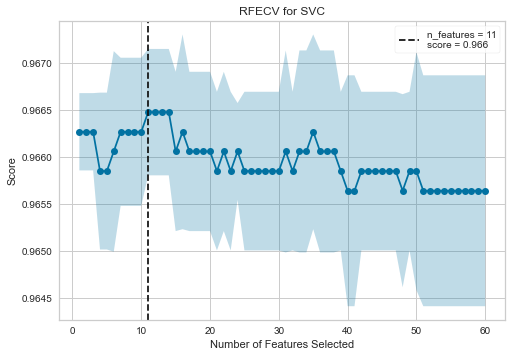

In [88]:
# Instantiate RFECV visualizer with a linear SVM classifier
visualizer_svc = RFECV(SVC(kernel='linear', C=1))

visualizer_svc.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer_svc.show()           # Finalize and render the figure

In [89]:
# Display features' names
most_relevent_cols = df.iloc[:, 1:].columns[np.where(visualizer_svc.support_ == True)]
print("Most relevant features based on linear SVM classifier are: ")
print(most_relevent_cols)

Most relevant features are: 
Index([' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Research and development expense rate',
       ' Realized Sales Gross Profit Growth Rate',
       ' After-tax Net Profit Growth Rate', ' Net Value Growth Rate',
       ' Quick Ratio', ' Accounts Receivable Turnover', ' Revenue per person',
       ' Quick Assets/Total Assets', ' Current Liability to Assets'],
      dtype='object')


##### * RFECV + RandomForest Classifier

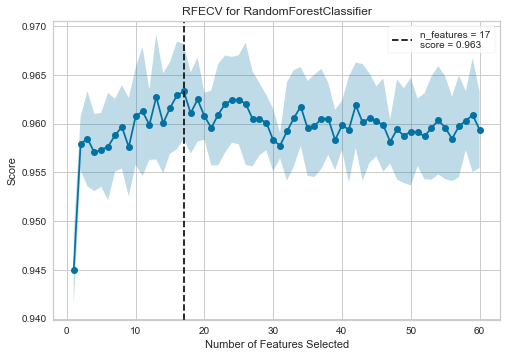

In [95]:
# Instantiate RFECV visualizer with a RandomForest classifier
cv = StratifiedKFold(5)
visualizer_rf = RFECV(RandomForestClassifier(), cv=cv, scoring='f1_weighted')

visualizer_rf.fit(X_train, y_train)       
visualizer_rf.show() 

In [96]:
# Display features' names
most_relevent_cols = df.iloc[:, 1:].columns[np.where(visualizer_rf.support_ == True)]
print("Most relevant features based on RandomForest Classifier are: ")
print(most_relevent_cols)

Most relevant features based on RandomForest Classifier are: 
Index([' ROA(C) before interest and depreciation before interest',
       ' Operating Gross Margin', ' Continuous interest rate (after tax)',
       ' Persistent EPS in the Last Four Seasons',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' After-tax Net Profit Growth Rate', ' Interest Expense Ratio',
       ' Debt ratio %', ' Long-term fund suitability ratio (A)',
       ' Operating profit/Paid-in capital', ' Accounts Receivable Turnover',
       ' Average Collection Days', ' Cash/Total Assets',
       ' Quick Assets/Current Liability', ' Cash/Current Liability',
       ' Current Liability to Assets'],
      dtype='object')


##### * RFECV + LogisticRegression 

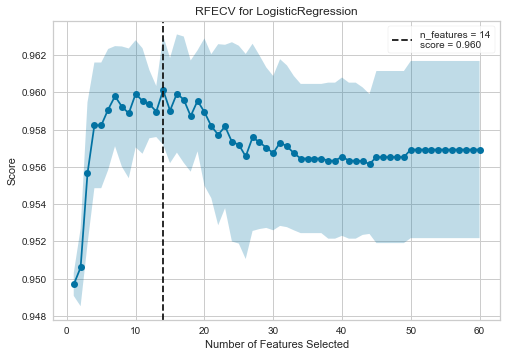

In [92]:
# Instantiate RFECV visualizer with a LogisticRegression

# Set number of folds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1) 
# Minimum number of features to consider
min_features_to_select = 1 

visualizer_lr = RFECV(LogisticRegression(max_iter=1000), cv=cv, scoring='f1_weighted',
                      min_features_to_select=min_features_to_select,n_jobs=1)
visualizer_lr.fit(X_train, y_train)       
visualizer_lr.show() 

In [93]:
# Display features' names
most_relevent_cols = df.iloc[:, 1:].columns[np.where(visualizer_lr.support_ == True)]
print("Most relevant features based on RandomForest Classifier are: ")
print(most_relevent_cols)

Most relevant features based on RandomForest Classifier are: 
Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Continuous interest rate (after tax)',
       ' Realized Sales Gross Profit Growth Rate', ' Total Asset Growth Rate',
       ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio',
       ' Current Ratio', ' Quick Ratio',
       ' Long-term fund suitability ratio (A)',
       ' Accounts Receivable Turnover', ' Net Worth Turnover Rate (times)',
       ' Current Liability to Assets'],
      dtype='object')


##### * Combine all the relevant features from all the three models above.

In [98]:
feature_list = ["Bankrupt?",
                ' ROA(C) before interest and depreciation before interest', 
                ' Persistent EPS in the Last Four Seasons',
                ' ROA(B) before interest and depreciation after tax', 
                ' Debt ratio %', 
                ' Operating Gross Margin', 
                ' Research and development expense rate',
                ' Continuous interest rate (after tax)', 
                ' After-tax Net Profit Growth Rate',
                ' Realized Sales Gross Profit Growth Rate', 
                ' Total Asset Growth Rate',
                ' Net Value Growth Rate', 
                ' Total Asset Return Growth Rate Ratio',
                ' Current Ratio', 
                ' Quick Ratio', 
                ' Quick Assets/Total Assets', 
                ' Revenue per person',
                ' Long-term fund suitability ratio (A)',
                ' Accounts Receivable Turnover', 
                ' Net Worth Turnover Rate (times)',
                ' Current Liability to Assets', 
                ' Interest Expense Ratio',
                ' Operating Profit Per Share (Yuan ¥)', 
                ' Operating profit/Paid-in capital', 
                ' Average Collection Days']

final_train = df.loc[:, df.columns.isin(feature_list)]
round(final_train.describe(),2)

Bankrupt?   ROA(C) before interest and depreciation before interest  \
count    6819.00                                            6819.00          
mean        0.03                                              -0.00          
std         0.18                                               1.00          
min         0.00                                              -8.33          
25%         0.00                                              -0.47          
50%         0.00                                              -0.04          
75%         0.00                                               0.50          
max         1.00                                               8.15          

        ROA(B) before interest and depreciation after tax  \
count                                            6819.00    
mean                                               -0.00    
std                                                 1.00    
min                                                -8.99    
25%                                                -0.43    
50%                                                -0.02    
75%                                                 0.50    
max                                                 7.25    

        Operating Gross Margin   Continuous interest rate (after tax)  \
count                  6819.00                                6819.00   
mean                      0.00                                  -0.00   
std                       1.00                                   1.00   
min                     -35.90                                 -61.63   
25%                      -0.44                                   0.01   
50%                      -0.12                                   0.02   
75%                       0.35                                   0.03   
max                      23.15                                  17.24   

        Research and development expense rate  \
count                                 6819.00   
mean                                     0.00   
std                                      1.00   
min                                     -0.75   
25%                                     -0.75   
50%                                     -0.55   
75%                                      0.58   
max                                      3.09   

        Persistent EPS in the Last Four Seasons  \
count                                   6819.00   
mean                                       0.00   
std                                        1.00   
min                                       -6.88   
25%                                       -0.42   
50%                                       -0.13   
75%                                        0.30   
max                                       23.19   

        Operating Profit Per Share (Yuan ¥)  \
count                               6819.00   
mean                                  -0.00   
std                                    1.00   
min                                   -3.90   
25%                                   -0.47   
50%                                   -0.17   
75%                                    0.25   
max                                   31.89   

        Realized Sales Gross Profit Growth Rate  \
count                                   6819.00   
mean                                       0.00   
std                                        1.00   
min                                       -1.86   
25%                                       -0.03   
50%                                       -0.03   
75%                                       -0.02   
max                                       80.94   

        After-tax Net Profit Growth Rate  ...   Interest Expense Ratio  \
count                            6819.00  ...                  6819.00   
mean                               -0.00  ...                    -0.00   
std                                 1.00  ...                     1.00   
min           

In [99]:
# Get the score on correlation
fX = final_train.drop(columns=["Bankrupt?"])
fy = final_train["Bankrupt?"]

select_features = SelectKBest(score_func=f_classif, k=10).fit(fX, fy)
select_features_kbest = pd.DataFrame({'Features': list(fX.columns),'Scores': select_features.scores_})
select_features_kbest.sort_values(by='Scores', ascending = False)

Features      Scores
1    ROA(B) before interest and depreciation after...  549.202093
0    ROA(C) before interest and depreciation befor...  497.535121
15                                       Debt ratio %  455.091151
5             Persistent EPS in the Last Four Seasons  345.267517
23                        Current Liability to Assets  268.012458
6                 Operating Profit Per Share (Yuan ¥)  140.388750
17                   Operating profit/Paid-in capital  138.500753
2                              Operating Gross Margin   68.918755
22                          Quick Assets/Total Assets   51.249983
10                              Net Value Growth Rate   29.219210
9                             Total Asset Growth Rate   13.484166
21                                 Revenue per person   10.771201
8                    After-tax Net Profit Growth Rate    9.745541
13                                        Quick Ratio    4.283205
4               Research and development expense rate    4.005214
20                    Net Worth Turnover Rate (times)    3.033236
16               Long-term fund suitability ratio (A)    1.952151
11               Total Asset Return Growth Rate Ratio    1.937815
3                Continuous interest rate (after tax)    0.480453
19                            Average Collection Days    0.292974
18                       Accounts Receivable Turnover    0.154063
14                             Interest Expense Ratio    0.048997
12                                      Current Ratio    0.033334
7             Realized Sales Gross Profit Growth Rate    0.001432

##### * Only keep 11 features in the end

In [100]:
# Remove the features with scores lower than 20
final_train.drop(' Total Asset Growth Rate', axis=1, inplace=True)
final_train.drop(' Revenue per person', axis=1, inplace=True)
final_train.drop(' After-tax Net Profit Growth Rate', axis=1, inplace=True)
final_train.drop(' Quick Ratio', axis=1, inplace=True)
final_train.drop(' Research and development expense rate', axis=1, inplace=True)
final_train.drop(' Net Worth Turnover Rate (times)', axis=1, inplace=True)
final_train.drop(' Long-term fund suitability ratio (A)', axis=1, inplace=True)
final_train.drop(' Total Asset Return Growth Rate Ratio', axis=1, inplace=True)
final_train.drop(' Continuous interest rate (after tax)', axis=1, inplace=True)
final_train.drop(' Average Collection Days', axis=1, inplace=True)
final_train.drop(' Accounts Receivable Turnover', axis=1, inplace=True)
final_train.drop(' Interest Expense Ratio', axis=1, inplace=True)
final_train.drop(' Current Ratio', axis=1, inplace=True)
final_train.drop(' Realized Sales Gross Profit Growth Rate', axis=1, inplace=True)

final_train.shape

(6819, 11)

<AxesSubplot:>

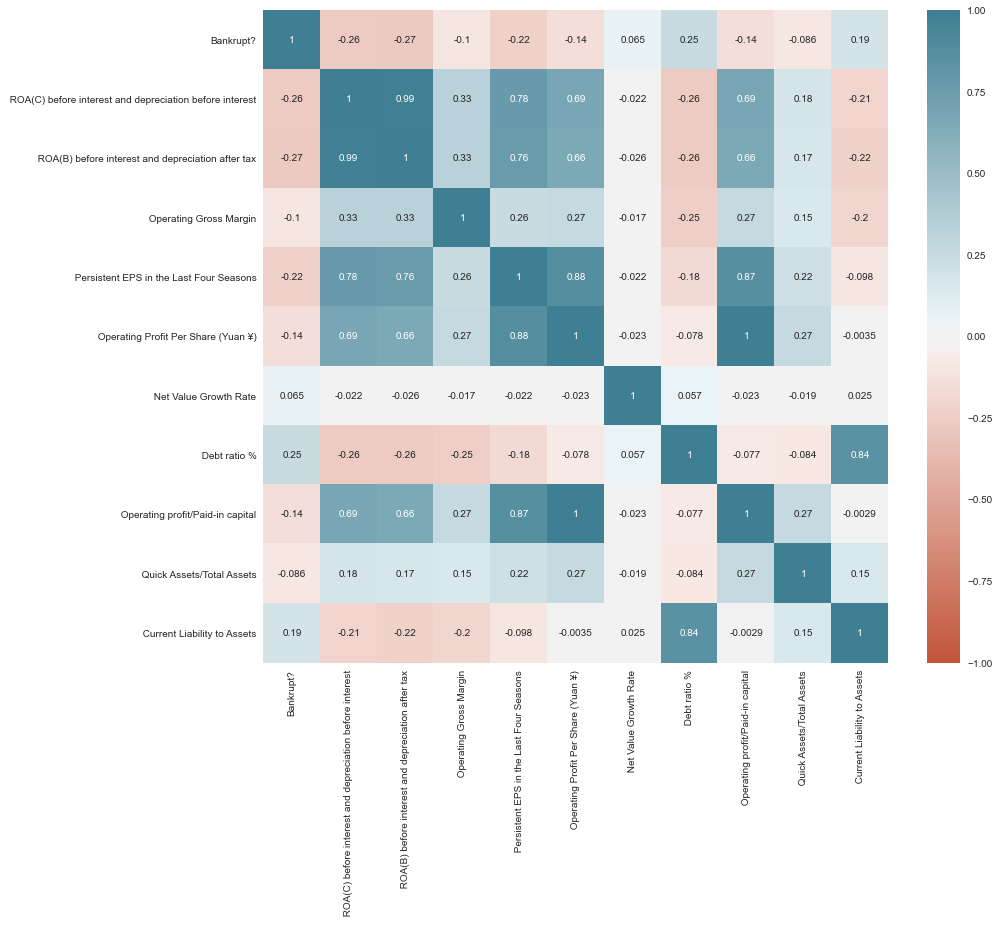

In [101]:
# final plot of correlation 
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(final_train.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), annot=True)

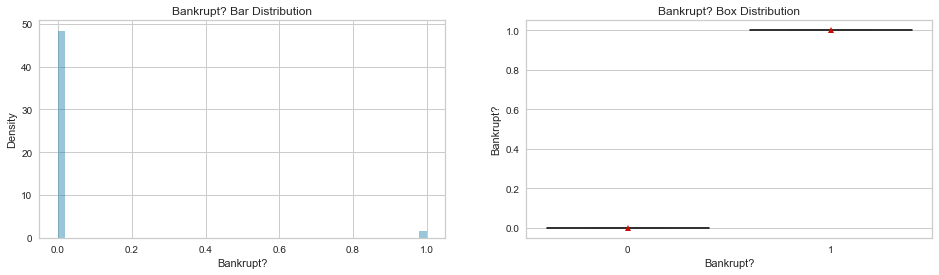

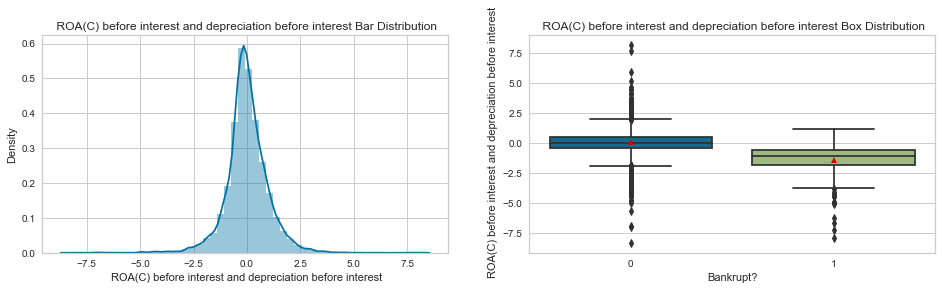

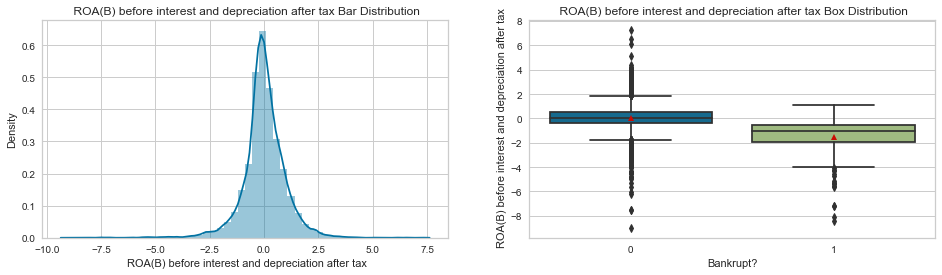

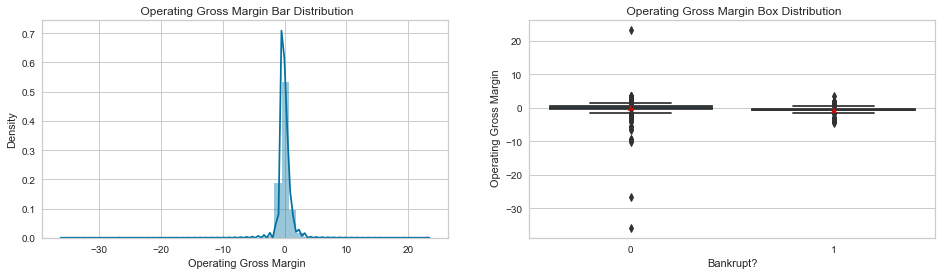

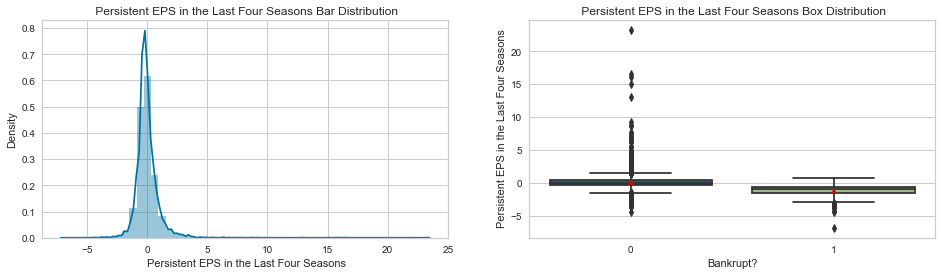

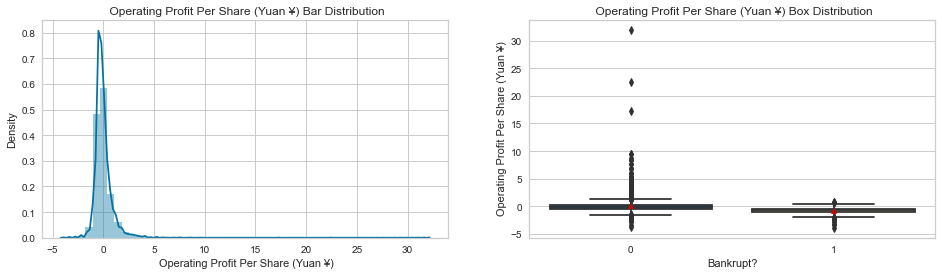

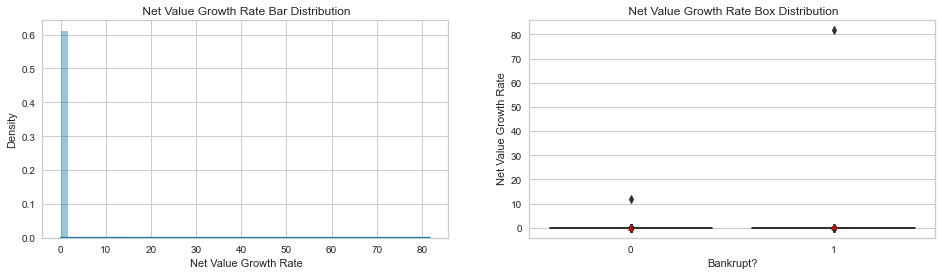

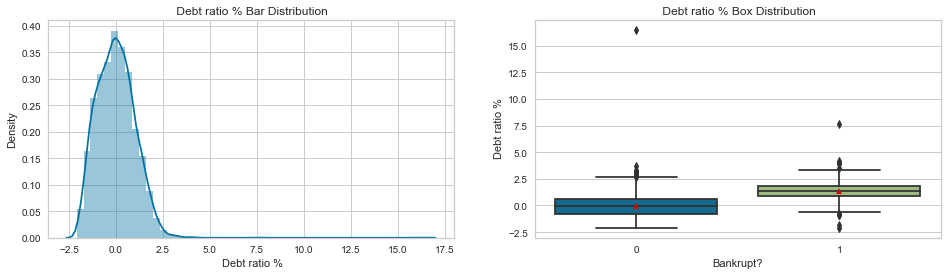

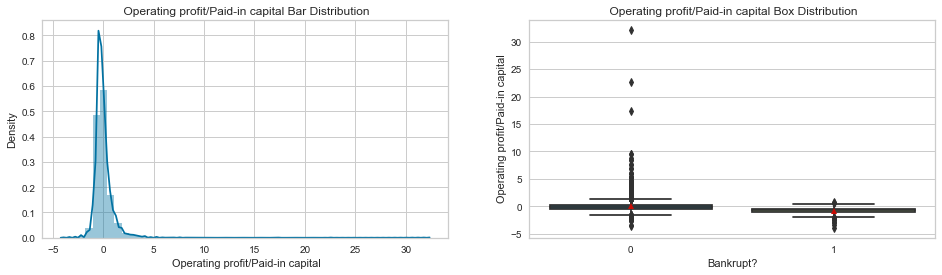

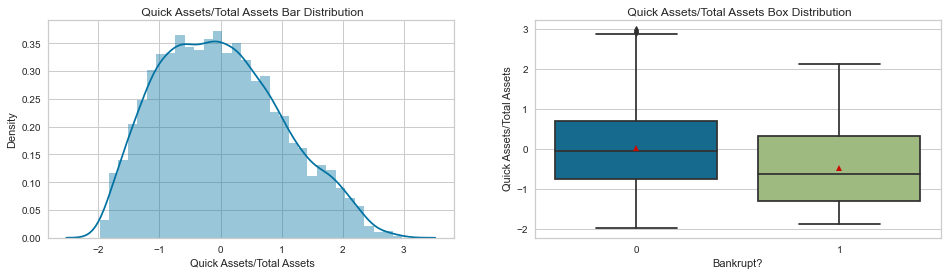

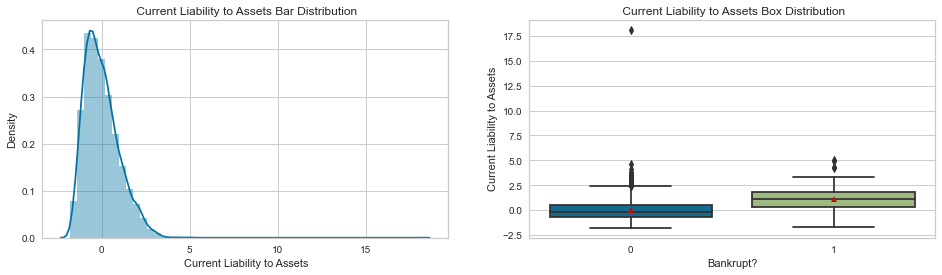

In [107]:
# add bar&box plot for each numeric variable 
for column in final_train.columns:
    # set the figure size 
    plt.figure(figsize=(16,4))
    
    # draw the bar chart
    plt.subplot(1,2,1)
    sns.distplot(final_train[column])
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'{column} Bar Distribution')
    
    # draw the box chart, group by "y"
    plt.subplot(1,2,2)
    sns.boxplot(x="Bankrupt?", y=column, data =final_train, showmeans=True )
    plt.xlabel("Bankrupt?")
    plt.ylabel(column)
    plt.title(f'{column} Box Distribution')

    plt.show()
    print()

## Oversample the minority class, using the SMOTE method

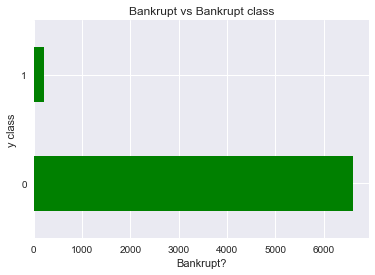

0    6599
1     220
Name: Bankrupt?, dtype: int64


In [102]:
# plot the imbalanced data again
plot_status_numberinit = final_train['Bankrupt?'].value_counts().plot(title = 'Bankrupt vs Bankrupt class', kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("Bankrupt?")
plot_status_numberinit.set_ylabel("y class")
plt.show()
print(final_train['Bankrupt?'].value_counts())

In [103]:
final_trainX = final_train.drop(columns=["Bankrupt?"])
final_trainy = final_train["Bankrupt?"]

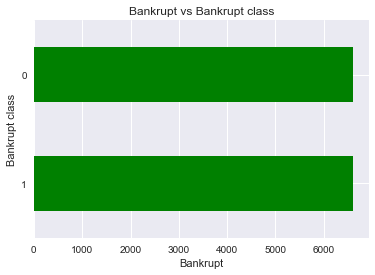

In [104]:
# oversample the minority class, using the SMOTE method
oversample = SMOTE()
new_train_X, new_train_y = oversample.fit_resample(final_trainX, final_trainy)

plot_status_numberinit = new_train_y.value_counts().plot(title = 'Bankrupt vs Bankrupt class', kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("Bankrupt")
plot_status_numberinit.set_ylabel("Bankrupt class")
plt.show()

In [105]:
df_train_final = pd.concat([new_train_y, new_train_X], axis=1, join='inner')
print(df_train_final.shape)
df_train_final.head()

(13198, 11)


Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                          -2.217909          
1          1                                          -0.673828          
2          1                                          -1.303672          
3          1                                          -1.735886          
4          1                                          -0.661778          

    ROA(B) before interest and depreciation after tax  \
0                                          -2.400361    
1                                          -0.598450    
2                                          -1.319910    
3                                          -1.556340    
4                                          -0.508050    

    Operating Gross Margin   Persistent EPS in the Last Four Seasons  \
0                -0.383334                                 -1.794106   
1                 0.135068                                 -0.597379   
2                -0.383759                                 -1.450153   
3                -1.441418                                 -1.055034   
4                -0.541238                                 -0.489361   

    Operating Profit Per Share (Yuan ¥)   Net Value Growth Rate  \
0                             -0.471371               -0.013721   
1                             -0.550058               -0.013721   
2                             -0.599601               -0.013721   
3                             -1.121264               -0.013721   
4                             -0.436400               -0.013721   

    Debt ratio %   Operating profit/Paid-in capital  \
0       1.750845                          -0.471275   
1       1.075727                          -0.548362   
2       1.749724                          -0.599655   
3       0.710131                          -1.124902   
4      -0.123674                          -0.433757   

    Quick Assets/Total Assets   Current Liability to Assets  
0                   -1.155833                      1.126267  
1                   -1.351081                     -0.670363  
2                   -0.296712                      0.148933  
3                   -1.181075                      0.159921  
4                   -0.692146                      0.388219

## Split the training data to actual_train and the validation part

In [106]:
# resplit the train data to training part and validation part (for model testing)
train_x, val_x, train_y, val_y = train_test_split(df_train_final.drop('Bankrupt?',axis=1),
                                                  df_train_final['Bankrupt?'],
                                                  test_size=0.3, random_state = 42)

In [107]:
# show the shape of the train and validation data
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((9238, 10), (3960, 10), (9238,), (3960,))

##### 注意
* test set: train_x, train_y -- (9238, 10), (9238,)
* validation set: val_x, val_y -- (3960, 10), (3960,)
* test data: df_test -- (2046, 95) 什么都没动

* apply models only on the test set, and use the validation set to select models
* choose the top 3 models and apply on the real test data

* 一定不要run feature selection的部分！！！可以跳过那里然后从feature_list = 一大堆那个column继续run（应该是104）
* 上面的包我#掉了，可以作为参考～

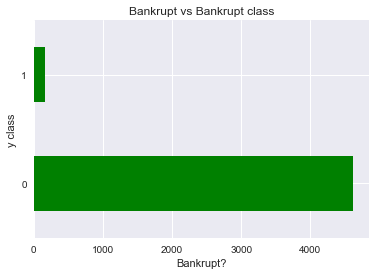

0    6599
1     220
Name: Bankrupt?, dtype: int64


In [108]:
plot_status_numberinit = df_train['Bankrupt?'].value_counts().plot(title = 'Bankrupt vs Bankrupt class', kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("Bankrupt?")
plot_status_numberinit.set_ylabel("y class")
plt.show()
print(final_train['Bankrupt?'].value_counts())

In [109]:
df_test = df_test.loc[:, df_test.columns.isin(feature_list)]
df_test.drop([' Total Asset Growth Rate',' Revenue per person', ' After-tax Net Profit Growth Rate',' Quick Ratio', ' Research and development expense rate',
              ' Net Worth Turnover Rate (times)',' Long-term fund suitability ratio (A)',' Total Asset Return Growth Rate Ratio',
              ' Continuous interest rate (after tax)',' Average Collection Days',' Accounts Receivable Turnover', ' Interest Expense Ratio',' Current Ratio',' Realized Sales Gross Profit Growth Rate'], axis=1, inplace=True)
test_x = df_test.iloc[:,1:]
test_y = df_test.iloc[:,0]

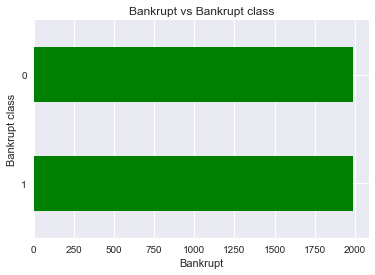

In [110]:
# oversample the minority class, using the SMOTE method
oversample = SMOTE()
test_x, test_y = oversample.fit_resample(test_x, test_y)

plot_status_numberinit = test_y.value_counts().plot(title = 'Bankrupt vs Bankrupt class', kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("Bankrupt")
plot_status_numberinit.set_ylabel("Bankrupt class")
plt.show()

In [114]:
train_y.shape

(9238,)

# Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(random_state = 42)
logistic_model.fit(train_x, train_y)
base_probs = ada_model.predict_proba(test_x)
base_pred = ada_model.predict(test_x)
base_probs_prob = base_probs[:,1]

print(sklearn.metrics.confusion_matrix(base_pred, test_y))
print(sklearn.metrics.classification_report(base_pred, test_y))
print(roc_auc_score(test_y, base_probs_prob))

[[1735  290]
 [ 252 1697]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2025
           1       0.85      0.87      0.86      1949

    accuracy                           0.86      3974
   macro avg       0.86      0.86      0.86      3974
weighted avg       0.86      0.86      0.86      3974

0.9390907532073728


# Neural Network

In [116]:
# ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

# early stopping
early_stop =  EarlyStopping(monitor='val_auc',mode='max', verbose=1, patience=27,restore_best_weights=True)

# ANN
model =  Sequential()

model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.10))

model.add(Dense(units=4,activation='relu'))

model.add(Dense(units=1,activation='sigmoid'))

# compile ANN
model.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [117]:
# Train ANN
model.fit(x=train_x, 
          y=train_y, 
          epochs=120,
          validation_data=(val_x, val_y), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/120
289/289 [==============================] - 1s 1ms/step - loss: 0.6053 - accuracy: 0.6202 - val_loss: 0.4330 - val_accuracy: 0.8487
Epoch 2/120
289/289 [==============================] - 0s 856us/step - loss: 0.4238 - accuracy: 0.8428 - val_loss: 0.3502 - val_accuracy: 0.8707
Epoch 3/120
289/289 [==============================] - 0s 907us/step - loss: 0.3652 - accuracy: 0.8586 - val_loss: 0.3231 - val_accuracy: 0.8742
Epoch 4/120
289/289 [==============================] - 0s 988us/step - loss: 0.3350 - accuracy: 0.8654 - val_loss: 0.3118 - val_accuracy: 0.8747
Epoch 5/120
289/289 [==============================] - 0s 917us/step - loss: 0.3264 - accuracy: 0.8664 - val_loss: 0.3066 - val_accuracy: 0.8742
Epoch 6/120
289/289 [==============================] - 0s 973us/step - loss: 0.3281 - accuracy: 0.8641 - val_loss: 0.3041 - val_accuracy: 0.8780
Epoch 7/120
289/289 [==============================] - 0s 890us/step - loss: 0.3164 - accuracy: 0.8687 - val_loss: 0.3020 - val_accu

Epoch 29/120
289/289 [==============================] - 0s 860us/step - loss: 0.2850 - accuracy: 0.8838 - val_loss: 0.2774 - val_accuracy: 0.8907
Epoch 30/120
289/289 [==============================] - 0s 858us/step - loss: 0.2703 - accuracy: 0.8883 - val_loss: 0.2767 - val_accuracy: 0.8902
Epoch 31/120
289/289 [==============================] - 0s 839us/step - loss: 0.2766 - accuracy: 0.8852 - val_loss: 0.2760 - val_accuracy: 0.8894
Epoch 32/120
289/289 [==============================] - 0s 848us/step - loss: 0.2834 - accuracy: 0.8822 - val_loss: 0.2761 - val_accuracy: 0.8934
Epoch 33/120
289/289 [==============================] - 0s 833us/step - loss: 0.2815 - accuracy: 0.8808 - val_loss: 0.2751 - val_accuracy: 0.8899
Epoch 34/120
289/289 [==============================] - 0s 836us/step - loss: 0.2773 - accuracy: 0.8878 - val_loss: 0.2737 - val_accuracy: 0.8917
Epoch 35/120
289/289 [==============================] - 0s 893us/step - loss: 0.2838 - accuracy: 0.8837 - val_loss: 0.2739 -

Epoch 57/120
289/289 [==============================] - 0s 925us/step - loss: 0.2685 - accuracy: 0.8916 - val_loss: 0.2581 - val_accuracy: 0.8970
Epoch 58/120
289/289 [==============================] - 0s 961us/step - loss: 0.2622 - accuracy: 0.8946 - val_loss: 0.2597 - val_accuracy: 0.8972
Epoch 59/120
289/289 [==============================] - 0s 949us/step - loss: 0.2694 - accuracy: 0.8903 - val_loss: 0.2598 - val_accuracy: 0.8982
Epoch 60/120
289/289 [==============================] - 0s 968us/step - loss: 0.2661 - accuracy: 0.8876 - val_loss: 0.2573 - val_accuracy: 0.8937
Epoch 61/120
289/289 [==============================] - 0s 950us/step - loss: 0.2682 - accuracy: 0.8906 - val_loss: 0.2570 - val_accuracy: 0.8972
Epoch 62/120
289/289 [==============================] - 0s 1ms/step - loss: 0.2576 - accuracy: 0.8908 - val_loss: 0.2571 - val_accuracy: 0.8985
Epoch 63/120
289/289 [==============================] - 0s 969us/step - loss: 0.2702 - accuracy: 0.8899 - val_loss: 0.2564 - v

Epoch 85/120
289/289 [==============================] - 0s 934us/step - loss: 0.2603 - accuracy: 0.8964 - val_loss: 0.2488 - val_accuracy: 0.8972
Epoch 86/120
289/289 [==============================] - 0s 1ms/step - loss: 0.2704 - accuracy: 0.8882 - val_loss: 0.2464 - val_accuracy: 0.8985
Epoch 87/120
289/289 [==============================] - 0s 990us/step - loss: 0.2531 - accuracy: 0.8999 - val_loss: 0.2481 - val_accuracy: 0.9003
Epoch 88/120
289/289 [==============================] - 0s 904us/step - loss: 0.2627 - accuracy: 0.8920 - val_loss: 0.2469 - val_accuracy: 0.9020
Epoch 89/120
289/289 [==============================] - 0s 872us/step - loss: 0.2606 - accuracy: 0.8932 - val_loss: 0.2469 - val_accuracy: 0.8990
Epoch 90/120
289/289 [==============================] - 0s 887us/step - loss: 0.2643 - accuracy: 0.8930 - val_loss: 0.2461 - val_accuracy: 0.9013
Epoch 91/120
289/289 [==============================] - 0s 927us/step - loss: 0.2557 - accuracy: 0.8987 - val_loss: 0.2487 - v

Epoch 113/120
289/289 [==============================] - 0s 825us/step - loss: 0.2610 - accuracy: 0.8963 - val_loss: 0.2426 - val_accuracy: 0.8982
Epoch 114/120
289/289 [==============================] - 0s 825us/step - loss: 0.2586 - accuracy: 0.8942 - val_loss: 0.2426 - val_accuracy: 0.8982
Epoch 115/120
289/289 [==============================] - 0s 827us/step - loss: 0.2499 - accuracy: 0.8910 - val_loss: 0.2412 - val_accuracy: 0.8997
Epoch 116/120
289/289 [==============================] - 0s 823us/step - loss: 0.2522 - accuracy: 0.8950 - val_loss: 0.2427 - val_accuracy: 0.9030
Epoch 117/120
289/289 [==============================] - 0s 825us/step - loss: 0.2522 - accuracy: 0.8949 - val_loss: 0.2438 - val_accuracy: 0.9023
Epoch 118/120
289/289 [==============================] - 0s 819us/step - loss: 0.2575 - accuracy: 0.8917 - val_loss: 0.2420 - val_accuracy: 0.8982
Epoch 119/120
289/289 [==============================] - 0s 827us/step - loss: 0.2472 - accuracy: 0.8971 - val_loss: 0

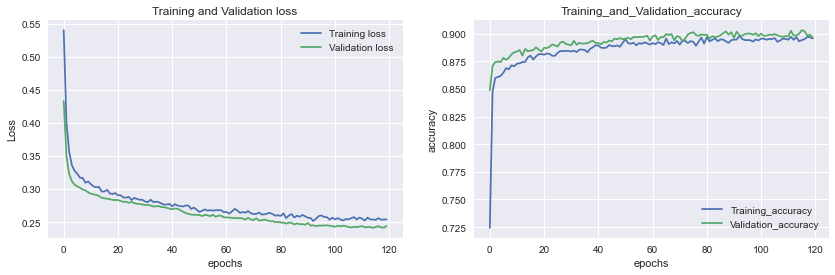

In [118]:
# model history to df
loss_plot = pd.DataFrame(model.history.history)
accuracy_plot = pd.DataFrame(model.history.history)

#  accuracy and loss plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,4))
plt.style.use('seaborn')
ax1.plot(loss_plot.loc[:, ['loss']], label='Training loss');
ax1.plot(loss_plot.loc[:, ['val_loss']],label='Validation loss');
ax1.set_title('Training and Validation loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc="best");

ax2.plot(accuracy_plot.loc[:, ['accuracy']],label='Training_accuracy');
ax2.plot(accuracy_plot.loc[:, ['val_accuracy']], label='Validation_accuracy');
ax2.set_title('Training_and_Validation_accuracy');
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend(loc="best");

In [119]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)

In [120]:
test_x.shape

(3974, 10)

In [121]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1987
           1       0.87      0.89      0.88      1987

    accuracy                           0.88      3974
   macro avg       0.88      0.88      0.88      3974
weighted avg       0.88      0.88      0.88      3974



<AxesSubplot:>

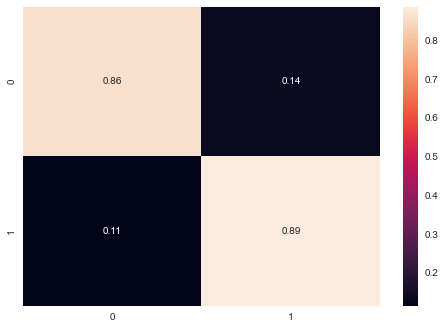

In [123]:
sns.heatmap(confusion_matrix(test_y,y_pred,normalize='true'), annot=True)

# Random Forest Classifier

In [124]:
#Random Forest Classifier 

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(train_x, train_y)

base_probs = rf_model.predict_proba(test_x)
base_pred = rf_model.predict(test_x)

import sklearn.metrics

print(sklearn.metrics.confusion_matrix(base_pred, test_y))
print(sklearn.metrics.classification_report(base_pred, test_y))

[[1962  193]
 [  25 1794]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2155
           1       0.90      0.99      0.94      1819

    accuracy                           0.95      3974
   macro avg       0.95      0.95      0.95      3974
weighted avg       0.95      0.95      0.95      3974



<AxesSubplot:xlabel='name'>

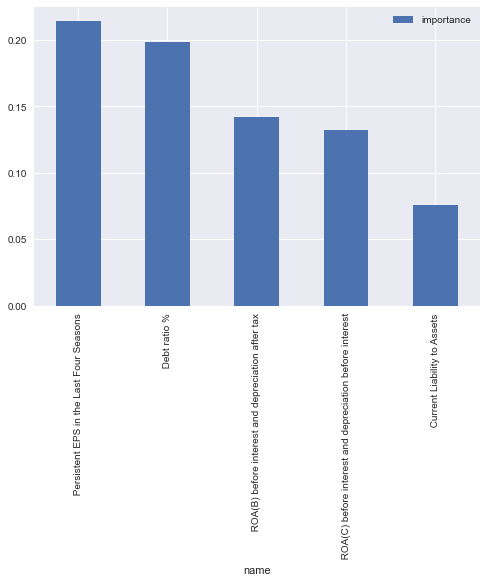

In [125]:
feature_importance = pd.DataFrame({'name': test_x.columns, 'importance': rf_model.feature_importances_})
feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance = feature_importance.iloc[0:5,:]
feature_importance.iloc[:,0:4].plot.bar(x='name', y='importance')

# Gradient Boosting Classifier

In [126]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

In [127]:
parameters = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.2,0.4,0.6],
        'max_depth': [1,2]
    
}

gb_grid = GridSearchCV(gb_model, parameters, cv=5, scoring='roc_auc',refit=True, n_jobs=-1, verbose=5)
gb_grid.fit(train_x, train_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.4, 0.6], 'max_depth': [1, 2],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='roc_auc', verbose=5)

In [128]:
gb_model2 = gb_grid.best_estimator_
gb_model2.fit(train_x, train_y)
base_probs = gb_model2.predict_proba(test_x)
base_pred = gb_model2.predict(test_x)
base_probs_prob = base_probs[:,1]

In [129]:
gb_model2

GradientBoostingClassifier(learning_rate=0.4, max_depth=2, n_estimators=400)

In [130]:
from sklearn.metrics import roc_auc_score
print(sklearn.metrics.confusion_matrix(base_pred, test_y))
print(sklearn.metrics.classification_report(base_pred, test_y))
print(roc_auc_score(test_y, base_probs_prob))

[[1879  203]
 [ 108 1784]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2082
           1       0.90      0.94      0.92      1892

    accuracy                           0.92      3974
   macro avg       0.92      0.92      0.92      3974
weighted avg       0.92      0.92      0.92      3974

0.976334093094799


<AxesSubplot:xlabel='name'>

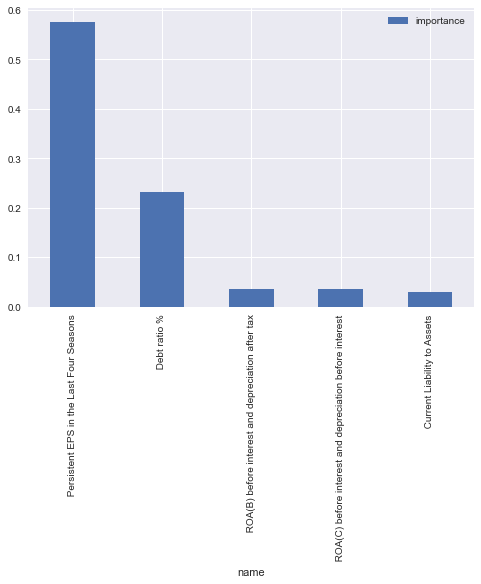

In [131]:
feature_importance = pd.DataFrame({'name': test_x.columns, 'importance': gb_model2.feature_importances_})
feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance = feature_importance.iloc[0:5,:]
feature_importance.iloc[:,0:4].plot.bar(x='name', y='importance')

# Ada Boost Classifier

In [132]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(random_state = 42)

ada_model.fit(train_x, train_y)
base_probs = ada_model.predict_proba(test_x)
base_pred = ada_model.predict(test_x)
base_probs_prob = base_probs[:,1]

print(sklearn.metrics.confusion_matrix(base_pred, test_y))
print(sklearn.metrics.classification_report(base_pred, test_y))
print(roc_auc_score(test_y, base_probs_prob))

[[1736  273]
 [ 251 1714]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2009
           1       0.86      0.87      0.87      1965

    accuracy                           0.87      3974
   macro avg       0.87      0.87      0.87      3974
weighted avg       0.87      0.87      0.87      3974

0.9412656854354511


<AxesSubplot:xlabel='name'>

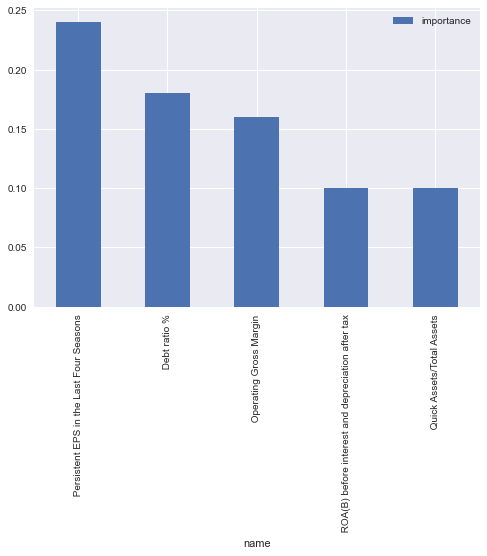

In [133]:
feature_importance = pd.DataFrame({'name': test_x.columns, 'importance': ada_model.feature_importances_})
feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance = feature_importance.iloc[0:5,:]
feature_importance.iloc[:,0:4].plot.bar(x='name', y='importance')